## Introduction

Before diving into any technical aspects, let's first introduce the objective, tools, and that we will be utilizing for this project. To complete setup, which includes the installation of required packages, modules, and datadets, please run `pip install -r requirements.txt` to download required packages for this notebook. 

For those of you simply browsing this notebook, you may view the specific package versions in the `requirements.txt` file. Next, let's move onto the technical details; **In a sentence, our objective is to explore the effect and permeation of idiosyncratic supply-side shocks with respect to the US Economy.** 

In [1]:
%cd ..

/Users/marko/Economic_Networks


In [1]:
## relevant libraries for EDA
import os
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
from collections import Counter
from matplotlib.pyplot import figure
import networkx as nx
import json
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.tsa.stattools as stattools
from econnet import data
import matplotlib.pyplot as plt
%matplotlib inline
## nice trick to increase dpi of exported images -> higher quality png's for presentation
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina', quality=600)

ModuleNotFoundError: No module named 'econnet'

In [1]:
## importing make, use, and supply tables
'''
data_path = f'{str(Path(os.getcwd()).parent)}/data/processed'
io_current = pd.read_csv(f'{data_path}/io_current.csv')
io_old = pd.read_csv(f'{data_path}/io_old.csv')
io_new = pd.read_csv(f'{data_path}/io_new.csv')
supply = pd.read_csv(f'{data_path}/supply.csv')
make_new = pd.read_csv(f'{data_path}/make_new.csv')
make_old = pd.read_csv(f'{data_path}/make_old.csv')
'''

"\ndata_path = f'{str(Path(os.getcwd()).parent)}/data/processed'\nio_current = pd.read_csv(f'{data_path}/io_current.csv')\nio_old = pd.read_csv(f'{data_path}/io_old.csv')\nio_new = pd.read_csv(f'{data_path}/io_new.csv')\nsupply = pd.read_csv(f'{data_path}/supply.csv')\nmake_new = pd.read_csv(f'{data_path}/make_new.csv')\nmake_old = pd.read_csv(f'{data_path}/make_old.csv')\n"

In [7]:
## import total requirements table
data_path = f'{str(Path(os.getcwd()).parent)}/stat222/Economic_Networks/data/processed'
# assign path
path, dirs, files = next(os.walk(f'{data_path}/../io-reqs-table'))
file_count = len(files)
files.sort()

# create empty list
reqs_master = []
  
# append datasets to the list 
for i in range(file_count):
    temp_df = pd.read_csv(path + "/" + files[i], sep=',', 
                skiprows = 4, header = [1]).iloc[:72,1:].set_index('Industry Description')
                
    reqs_master.append(temp_df)

StopIteration: 

## Data Cleaning & Transformation

This section contains a basic sample of the BEA Input-Output data and a couple of sample statistics which will be stated in our presentation.

- **Supply tables:** The value of goods and services available in the U.S. economy, whether produced by domestic industries or imported. 
- **Use tables:** How the supply of goods and services is used. Includes purchases by U.S. industries, individuals, and government, and exports to foreign purchasers. 


In [8]:
## function to grab row totals
def grab_row_totals(df):
    # grabs the total intermediate, total value added, and total industry output for the years
    return df[(df['Name'] == 'Total Intermediate') | (df['Name'] == 'Total Value Added') | (df['Name'] == 'Total Industry Output')]

grab_row_totals(io_old)

def output_diff(df, primary_name, secondary_name, output_name):
    # looks at the differences of the industry output from the subtotals for io tables
    diff = df[primary_name] + df[secondary_name] - df[output_name]
    diff = diff.iloc[:-6]
    return diff
    
output_diff(io_current, 'Total Intermediate', 'Total Final Uses (GDP)', 'Total Commodity Output')
output_diff(supply, 'Total product supply (basic prices)', 'Total tax less subsidies on products', 'Total product supply (purchaser prices)')

0      -57209
1       -8108
2      -26699
3      -18697
4           0
        ...  
1765        1
1766        1
1767        0
1768        0
1769        0
Length: 1770, dtype: int64

In [9]:
df = io_current.copy()
tio = df[df['Name'] == 'Total Industry Output'].set_index('year').drop(['Name','Total Commodity Output','Total Final Uses (GDP)'], axis = 1) 
tva = df[df['Name'] == 'Total Value Added'].set_index('year').drop(['Name','Total Commodity Output'], axis = 1)
ti = df[df['Name'] == 'Total Intermediate'].set_index('year').drop(['Name','Total Commodity Output','Total Final Uses (GDP)'], axis = 1) 

## Exploratory EDA

This section concerns the exploration of time-indexed commodity data - I admit that the depth of this portion may be lacking, but alas, we must show a couple of fancy plots before we dive into the project itself.

### Defenitions

- Total Industry Output: principally a measure of sales or revenue from production for most industries, although it is measured as sales or revenue less cost of goods sold for margin industries like retail and wholesale trade.
  
- Total Value Added: Value added is the difference between gross output and intermediate inputs and represents the value of labor and capital used in producing gross output. The sum of value added across all industries is equal to gross domestic product for the economy. Value added is also measured as the sum of an industry’s compensation of employees, taxes on production and imports, less subsidies, and gross operating surplus.
  
- Total Intermediate: Intermediate inputs are the foreign and domestically-produced goods and services used up by an industry in the process of producing its gross output. 

Next, I have also listed; these statements may be confirmed visually with the plots shown below. Note that there are a total

### Observations:

- Forestry is the largest contributer to 'Total Intermediatte' value consistenly over two decades - it seems that almsot every industry has a heavy relianace on wood as a core material.

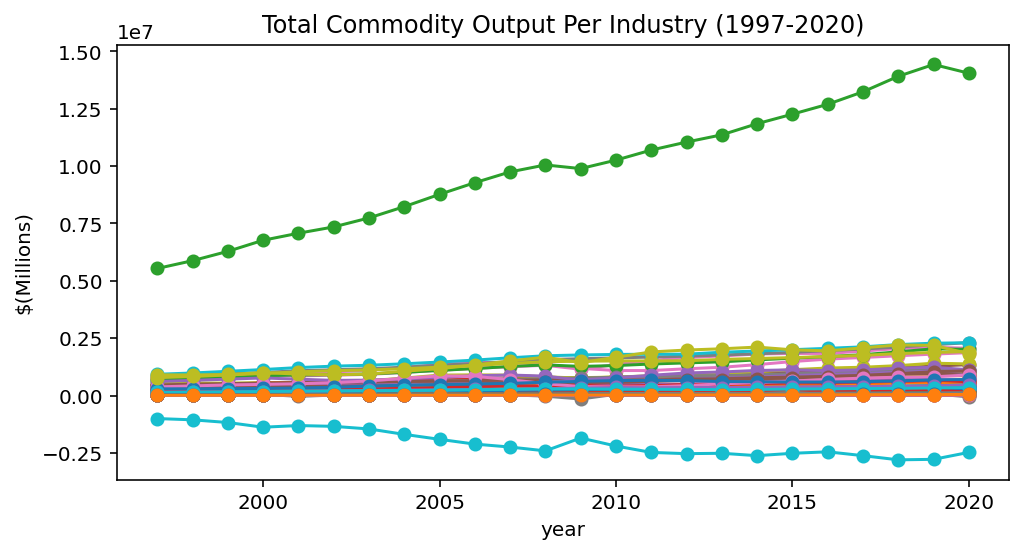

In [10]:
## Total Commodity Output of US Economy over time
plt.rcParams["figure.figsize"] = (8,4)
tio.plot(legend=None, marker = 'o')
plt.title('Total Commodity Output Per Industry (1997-2020)')
plt.ylabel('$(Millions)')
plt.show()

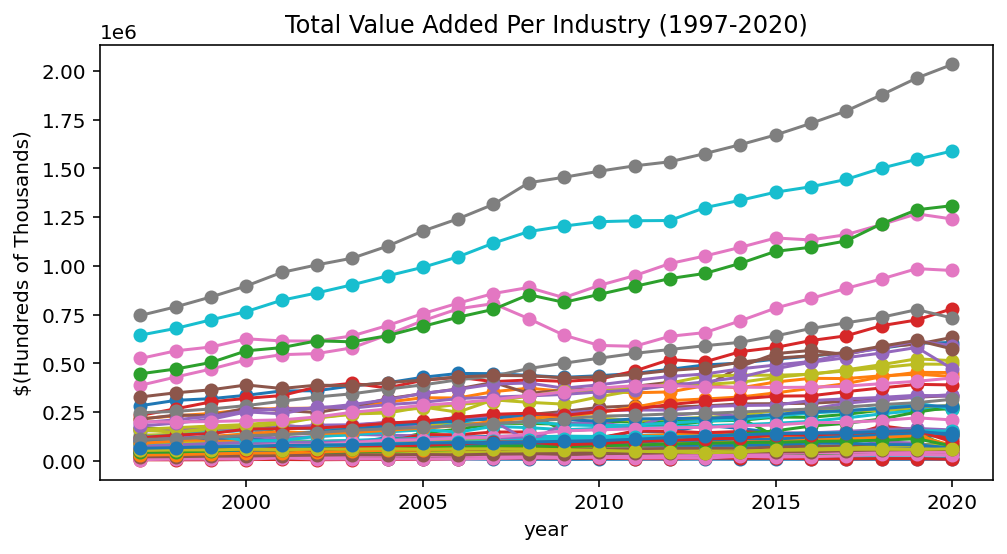

In [11]:
## TVA per industry indexed by years
## plots are split into batches of 5 industries
plt.rcParams["figure.figsize"] = (8,4)
tva.drop('Total Final Uses (GDP)', axis = 1).plot(legend = False, marker = 'o')
plt.title('Total Value Added Per Industry (1997-2020)')
plt.ylabel('$(Hundreds of Thousands)')
plt.show()

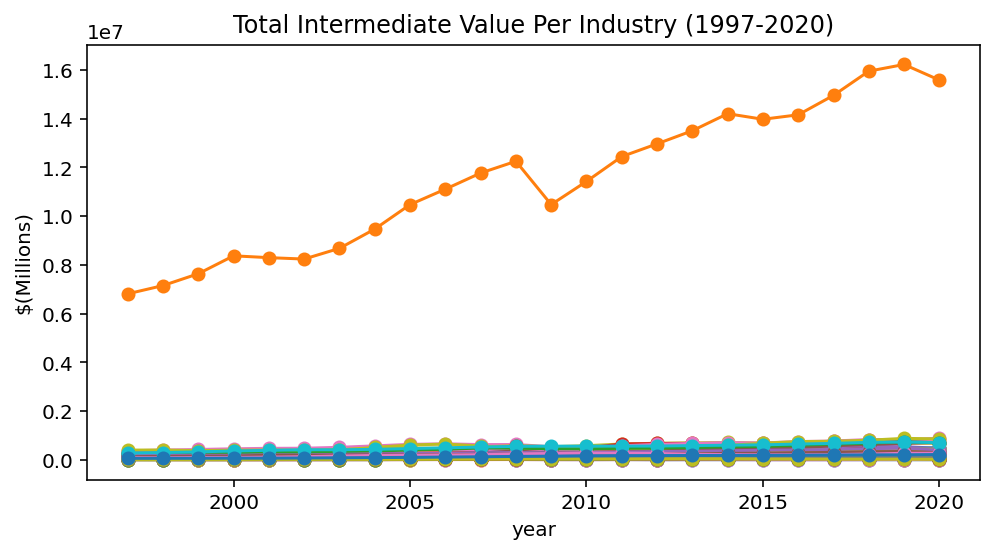

In [12]:
plt.rcParams["figure.figsize"] = (8,4)
ti.plot(legend=None, marker = 'o') ## forestry adds a large Total Intermediate Value [orange line]
plt.title('Total Intermediate Value Per Industry (1997-2020)')
plt.ylabel('$(Millions)')
plt.show()

### Centrality

Next, let's consider the measure of 'network centrality'.

In [13]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://upload.wikimedia.org/wikipedia/commons/1/11/6_centrality_measures.png", width=1000, height=1500)

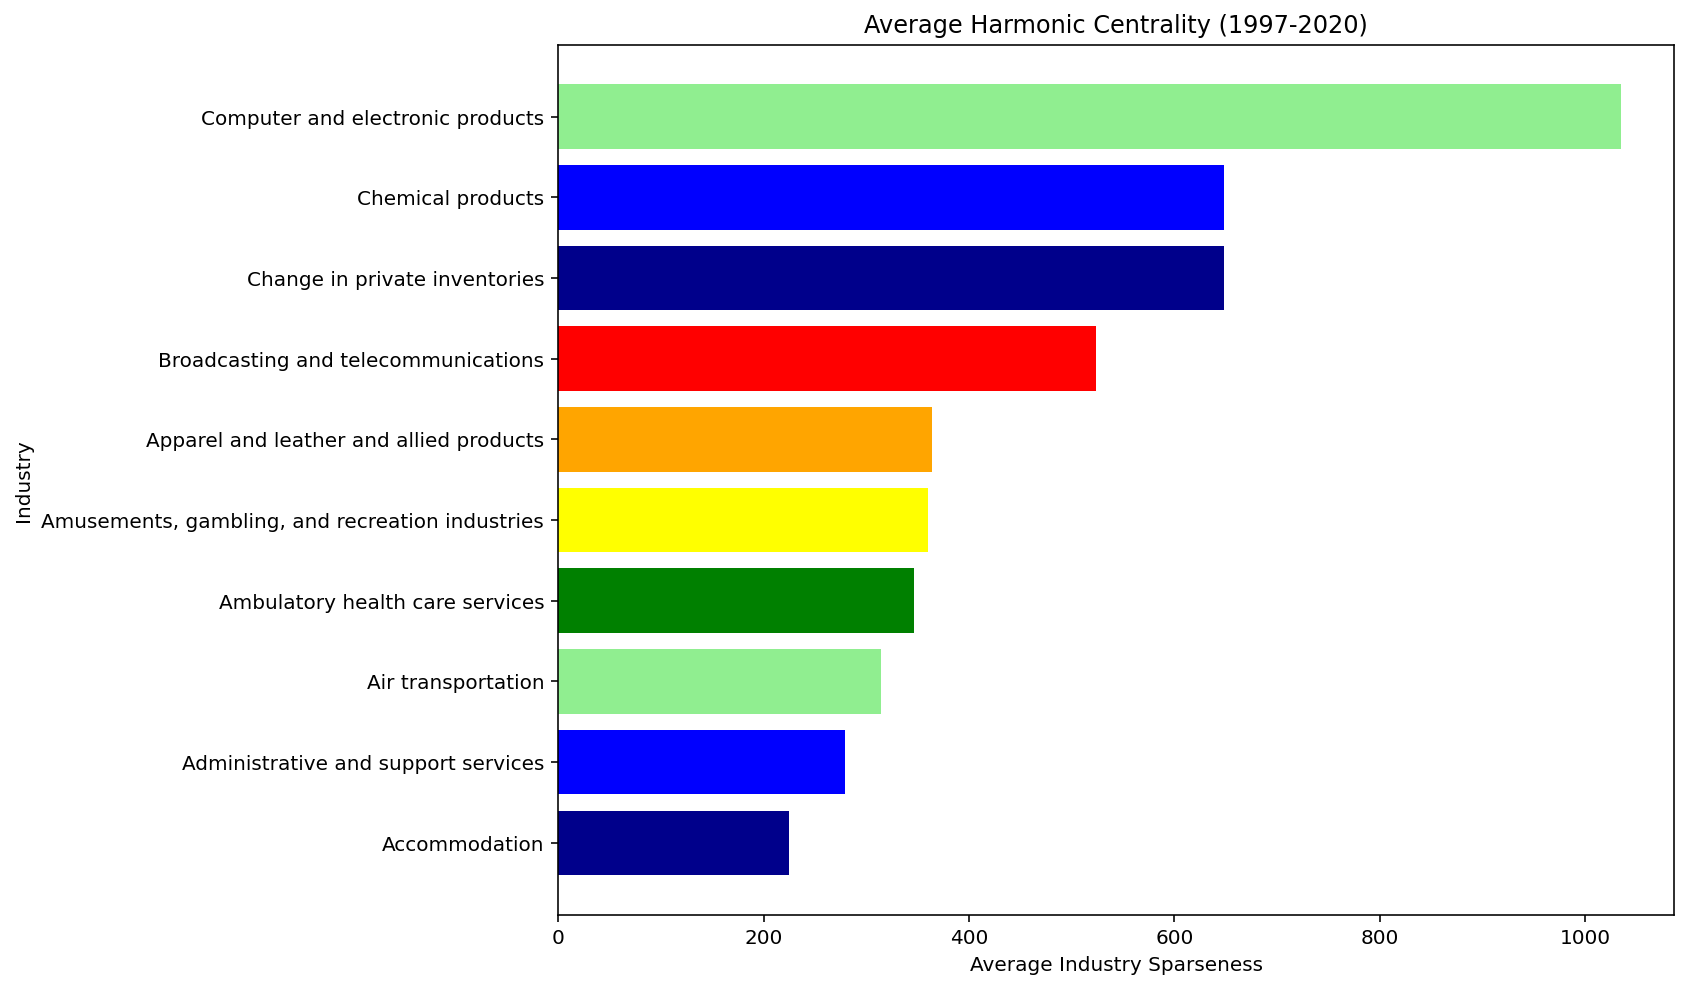

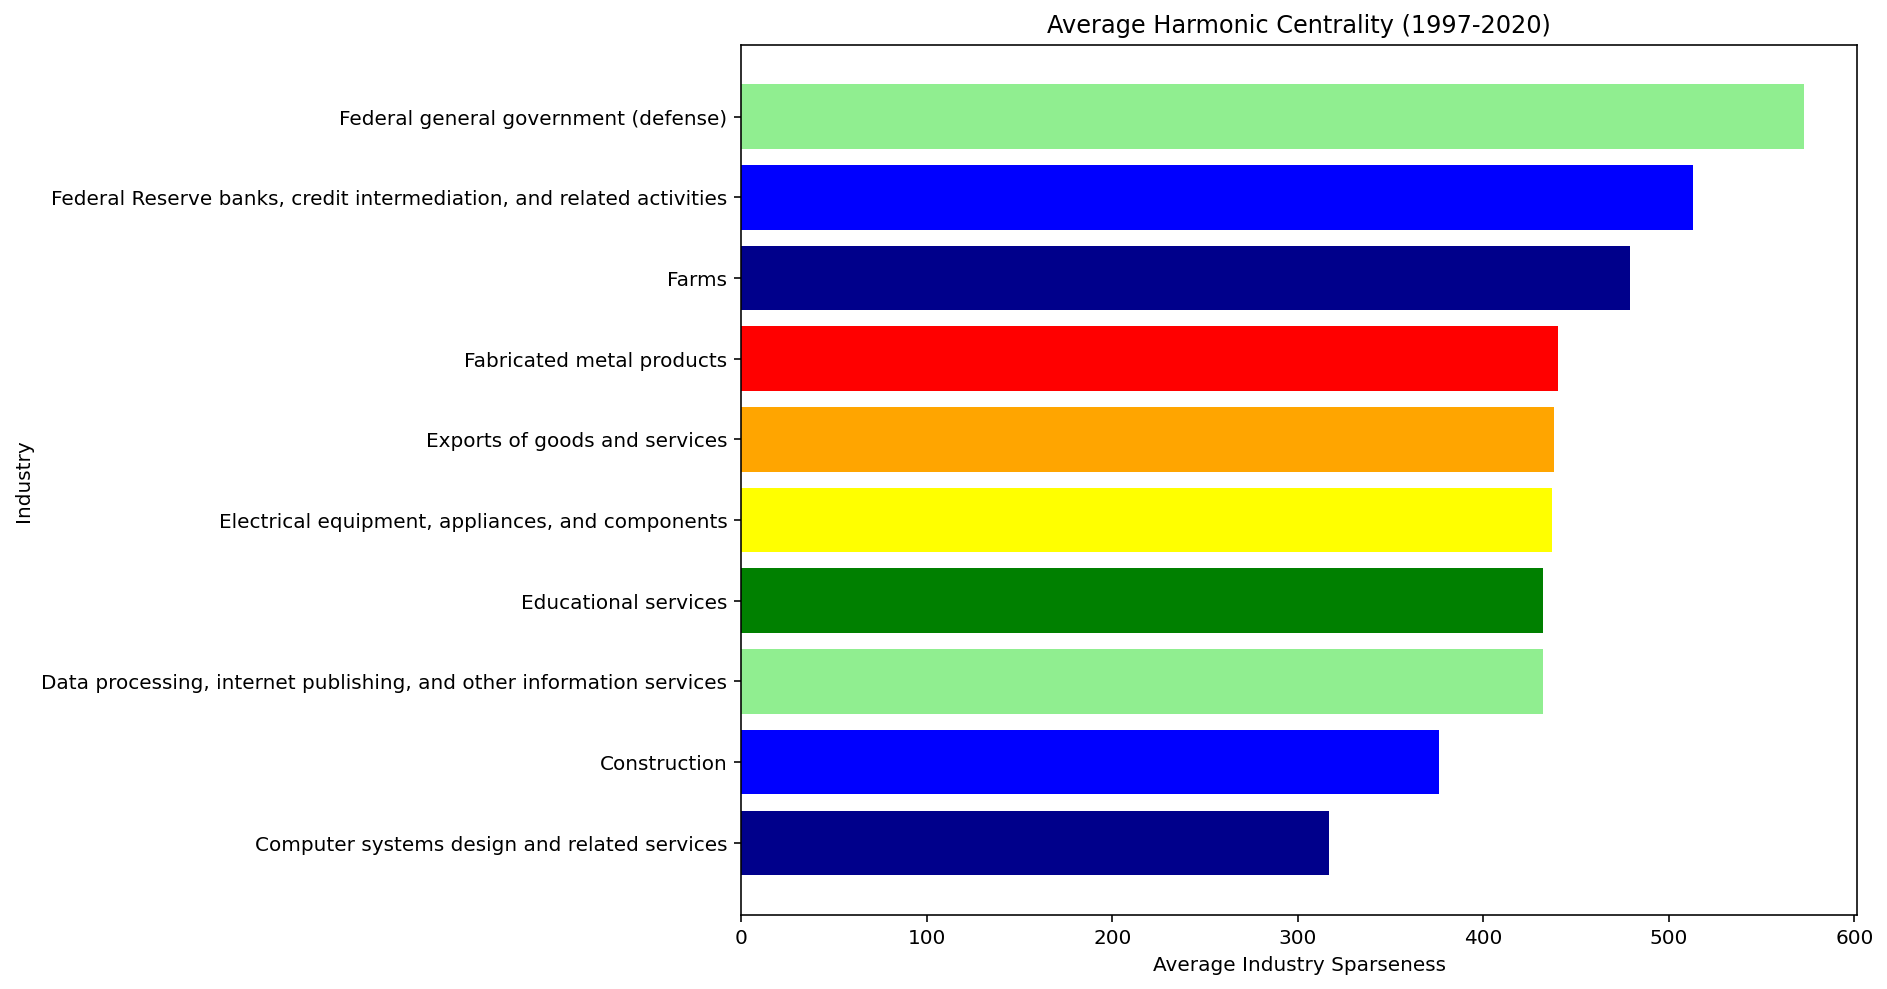

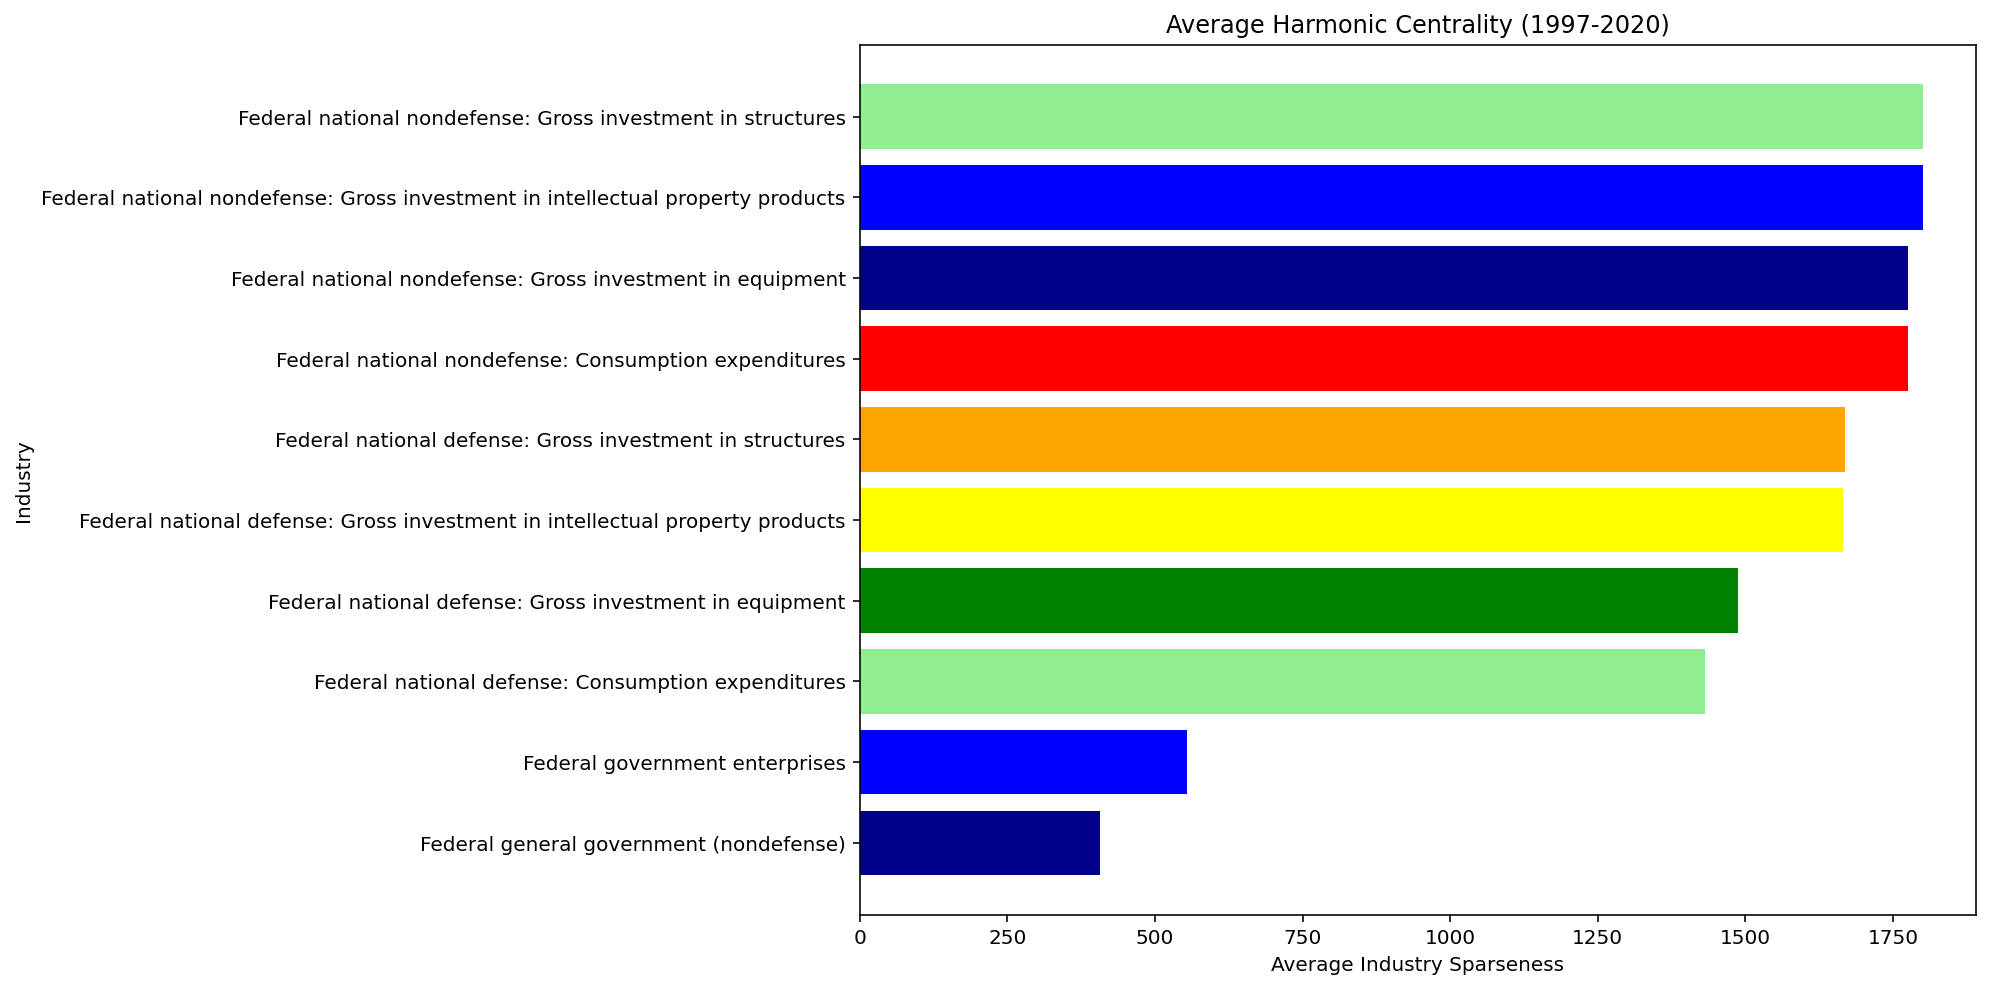

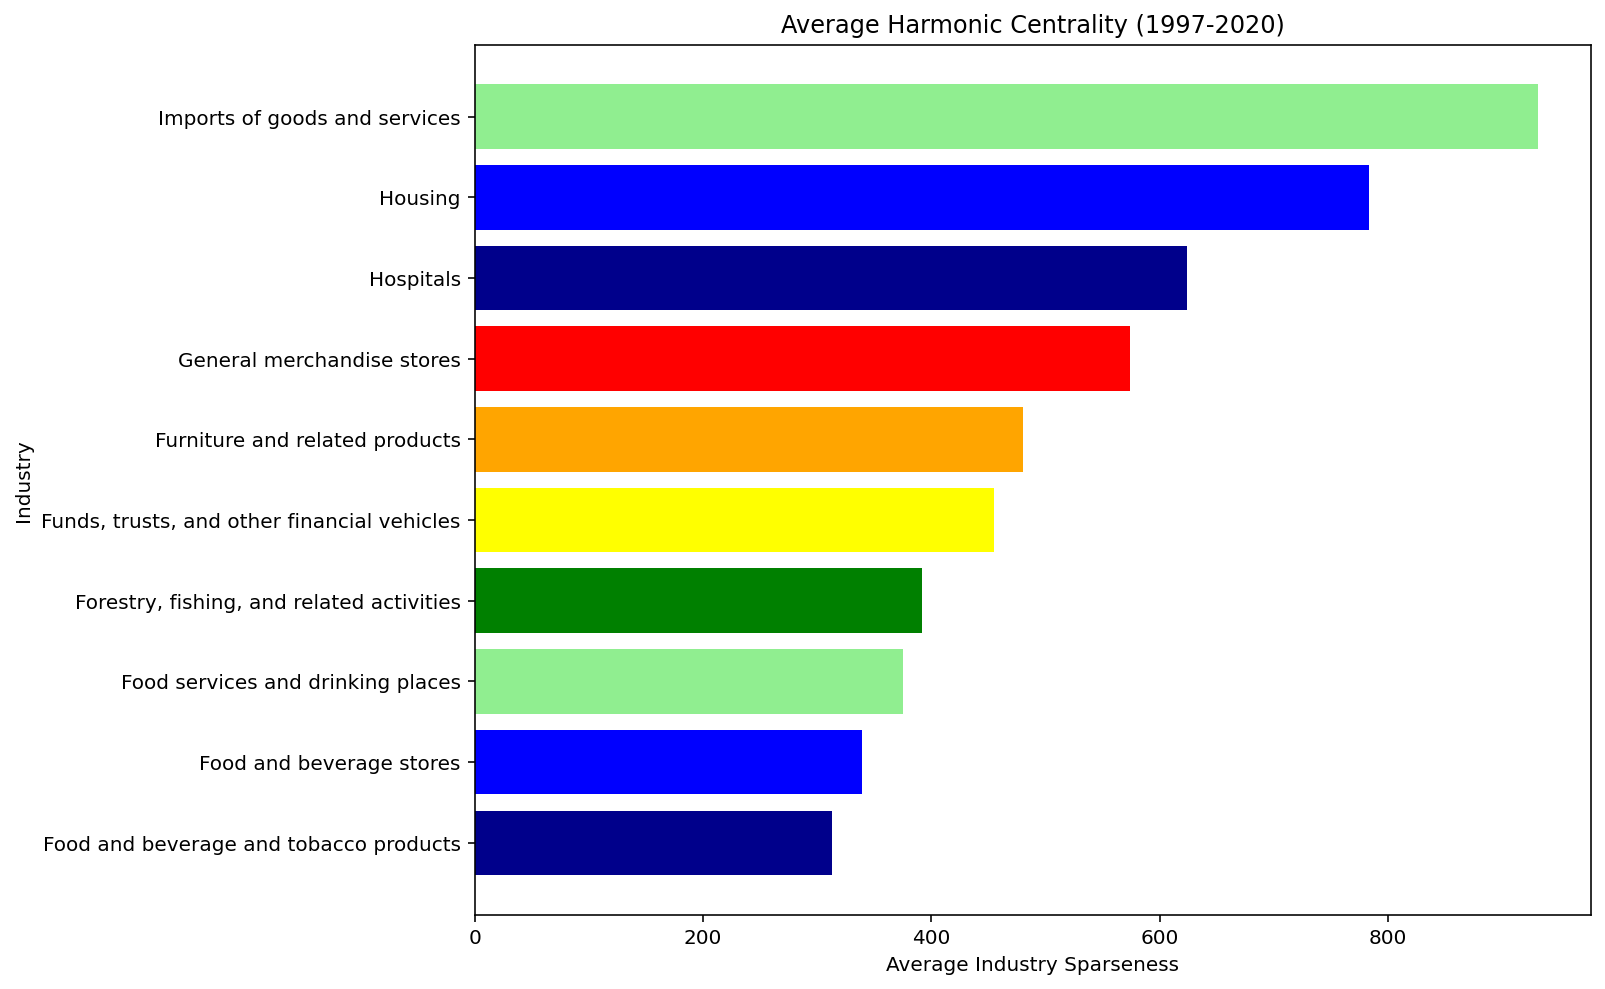

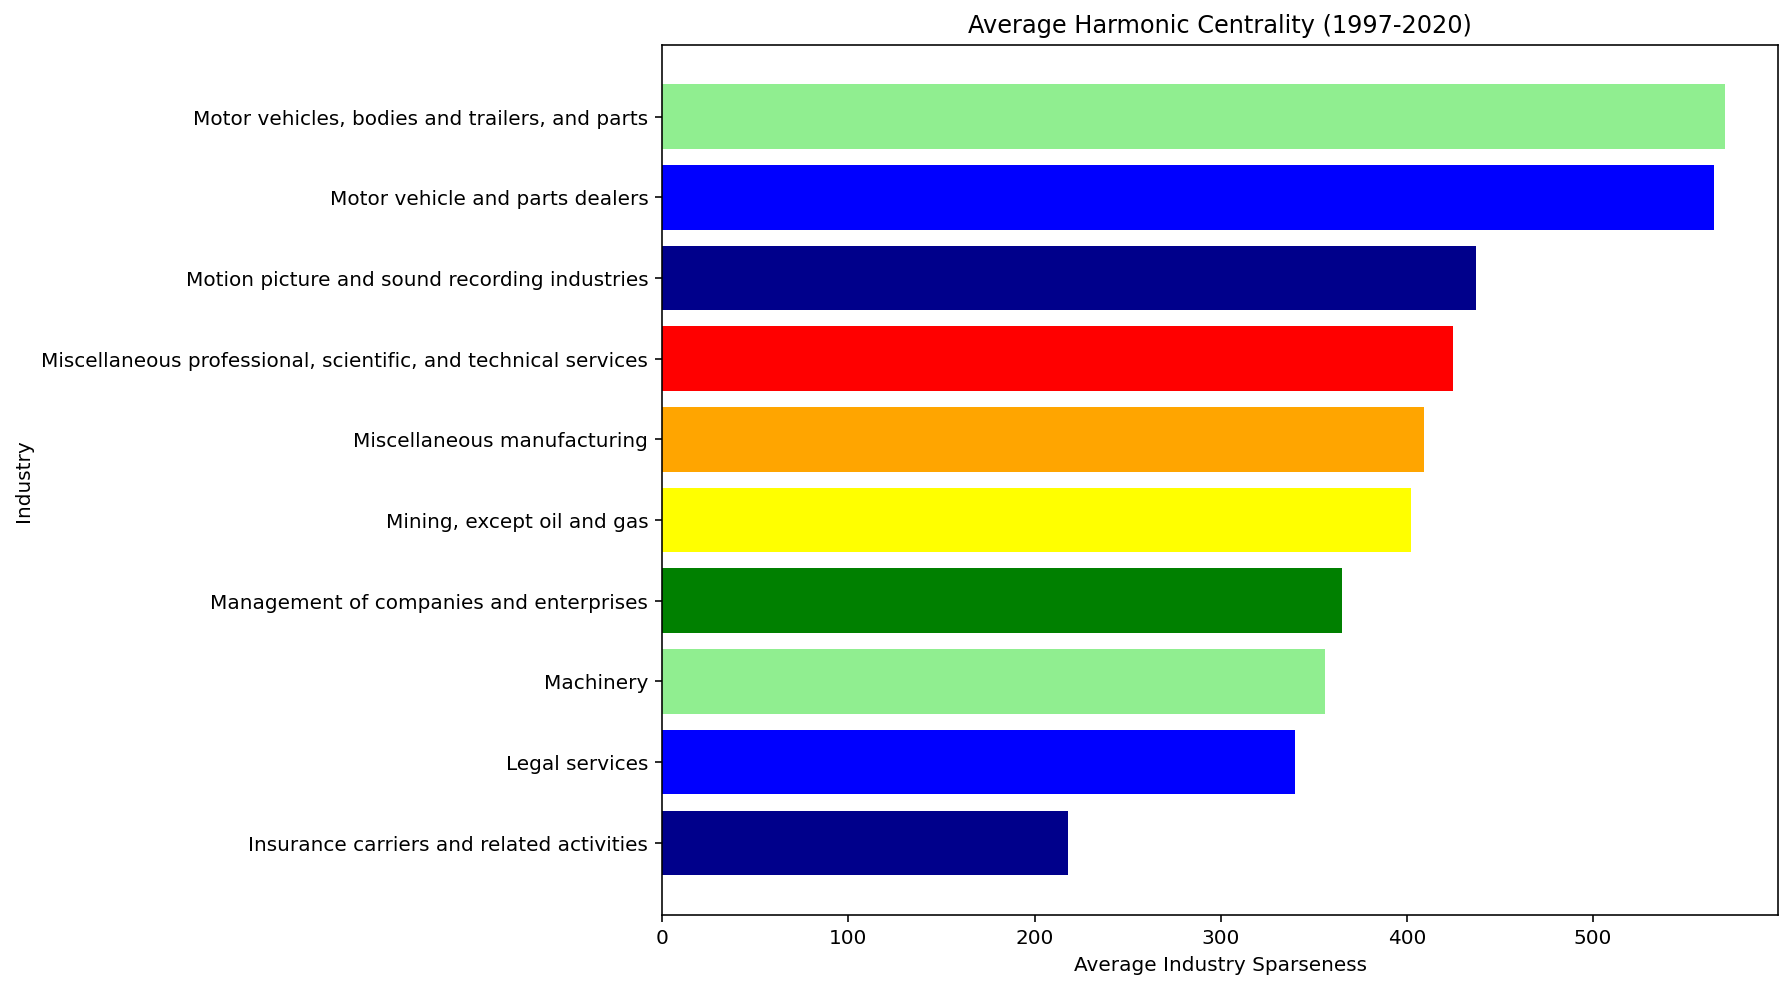

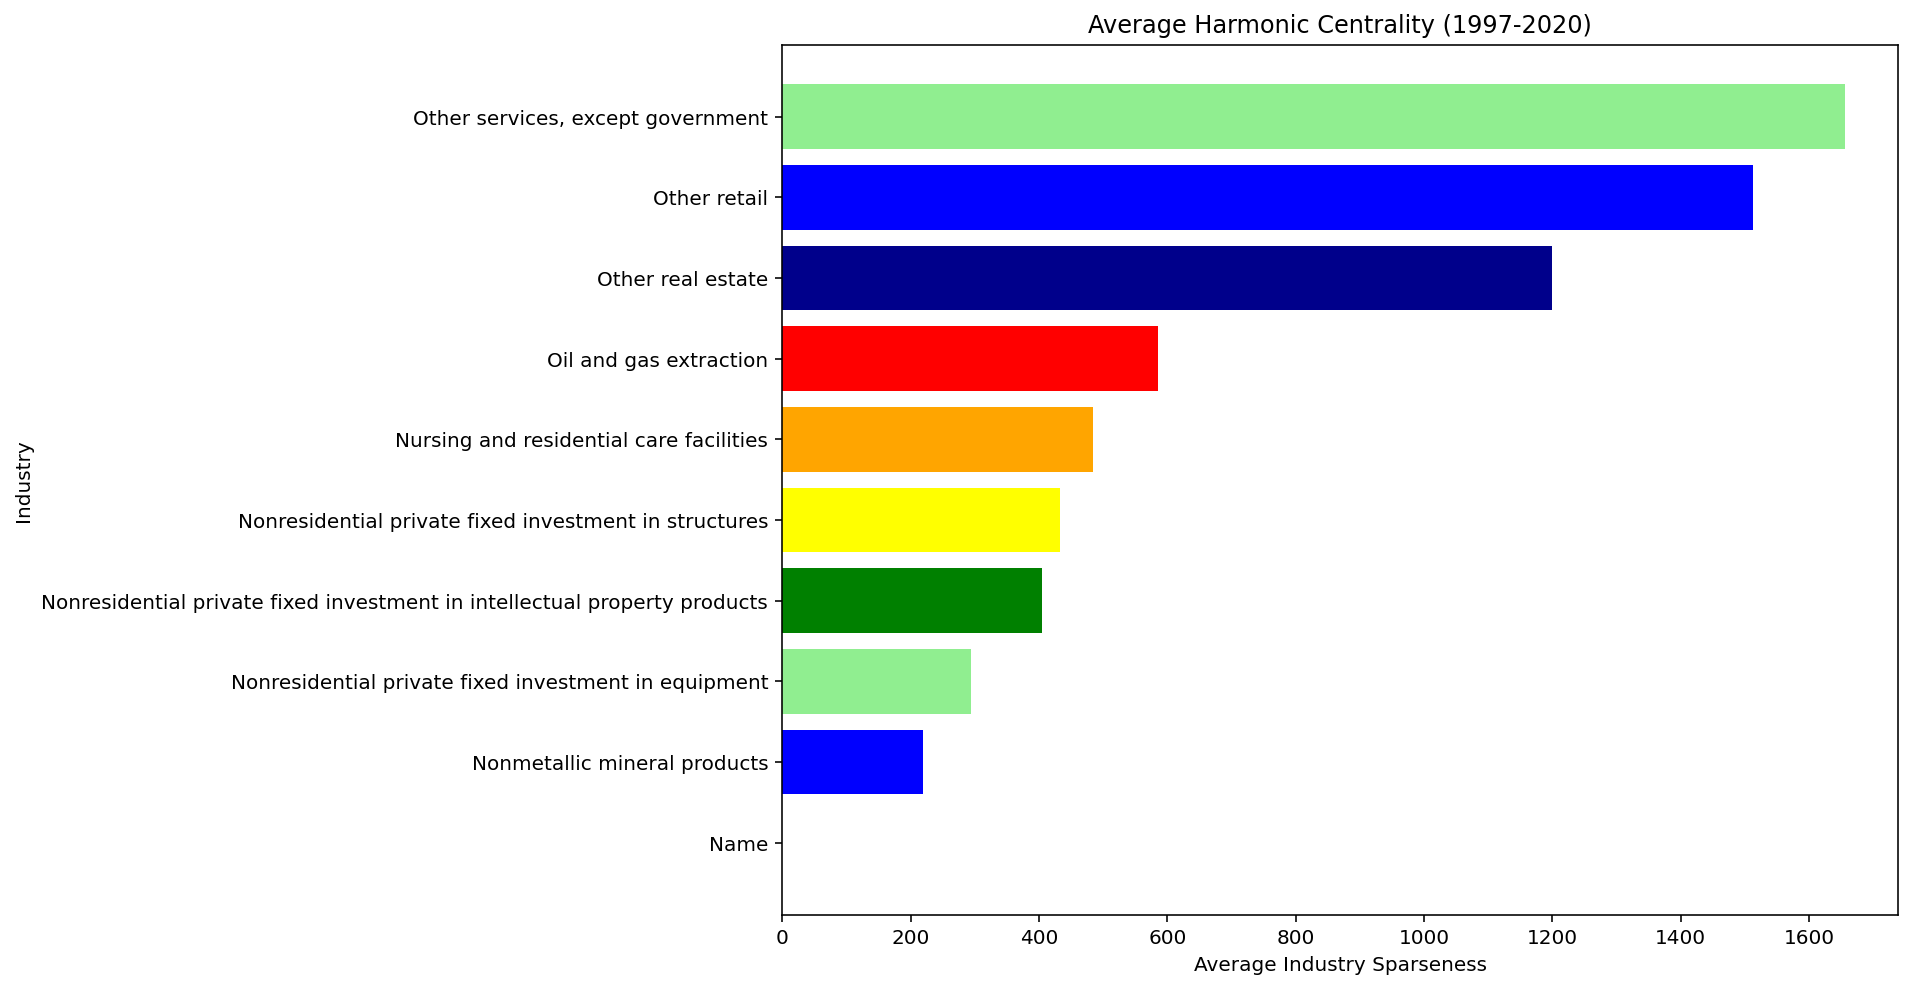

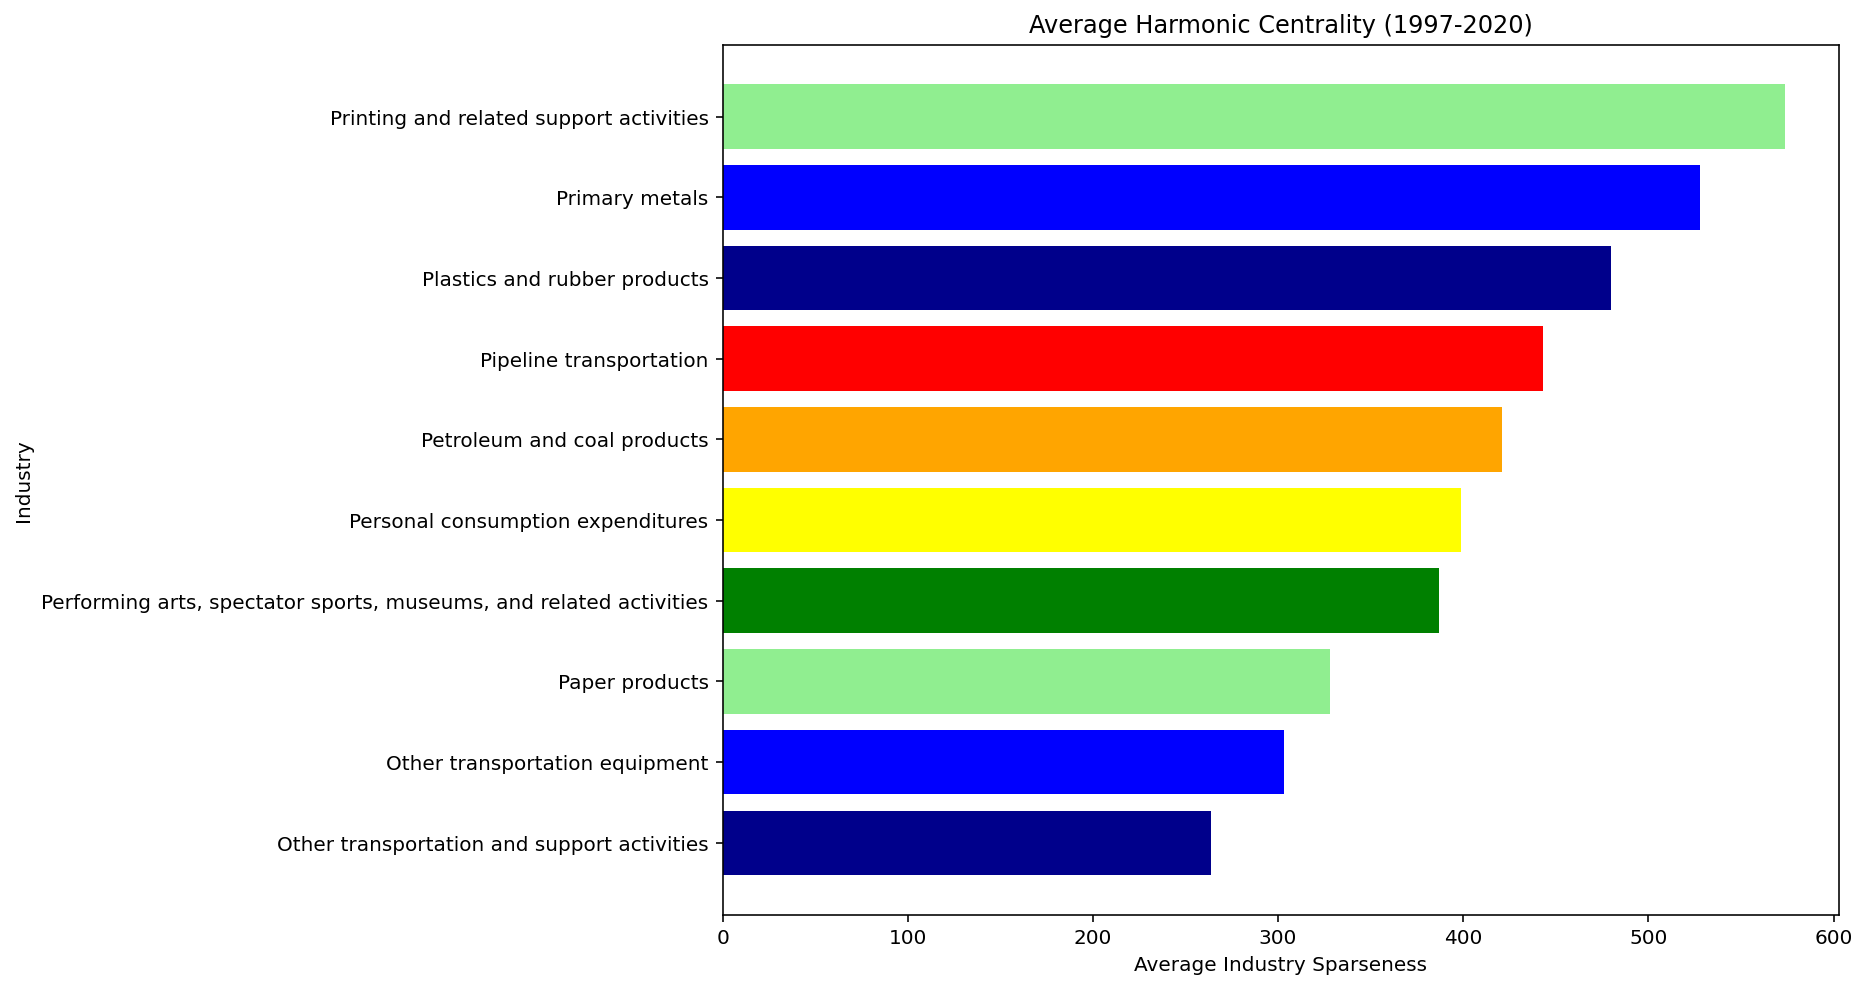

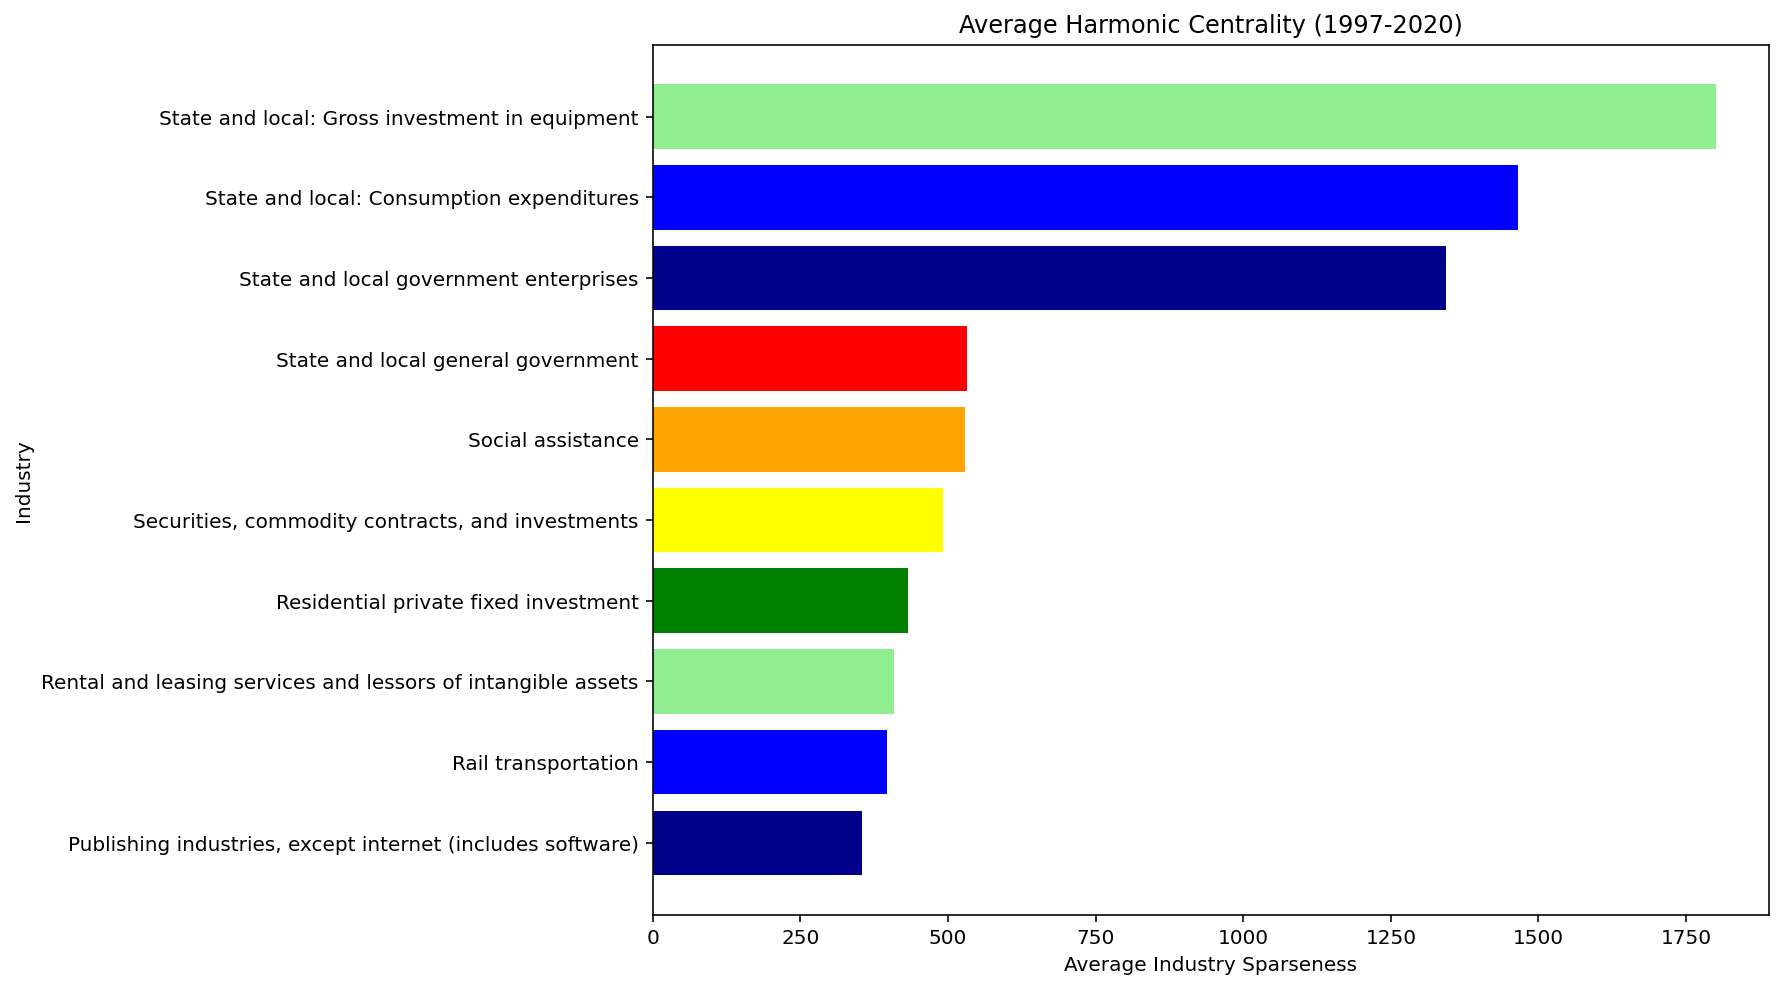

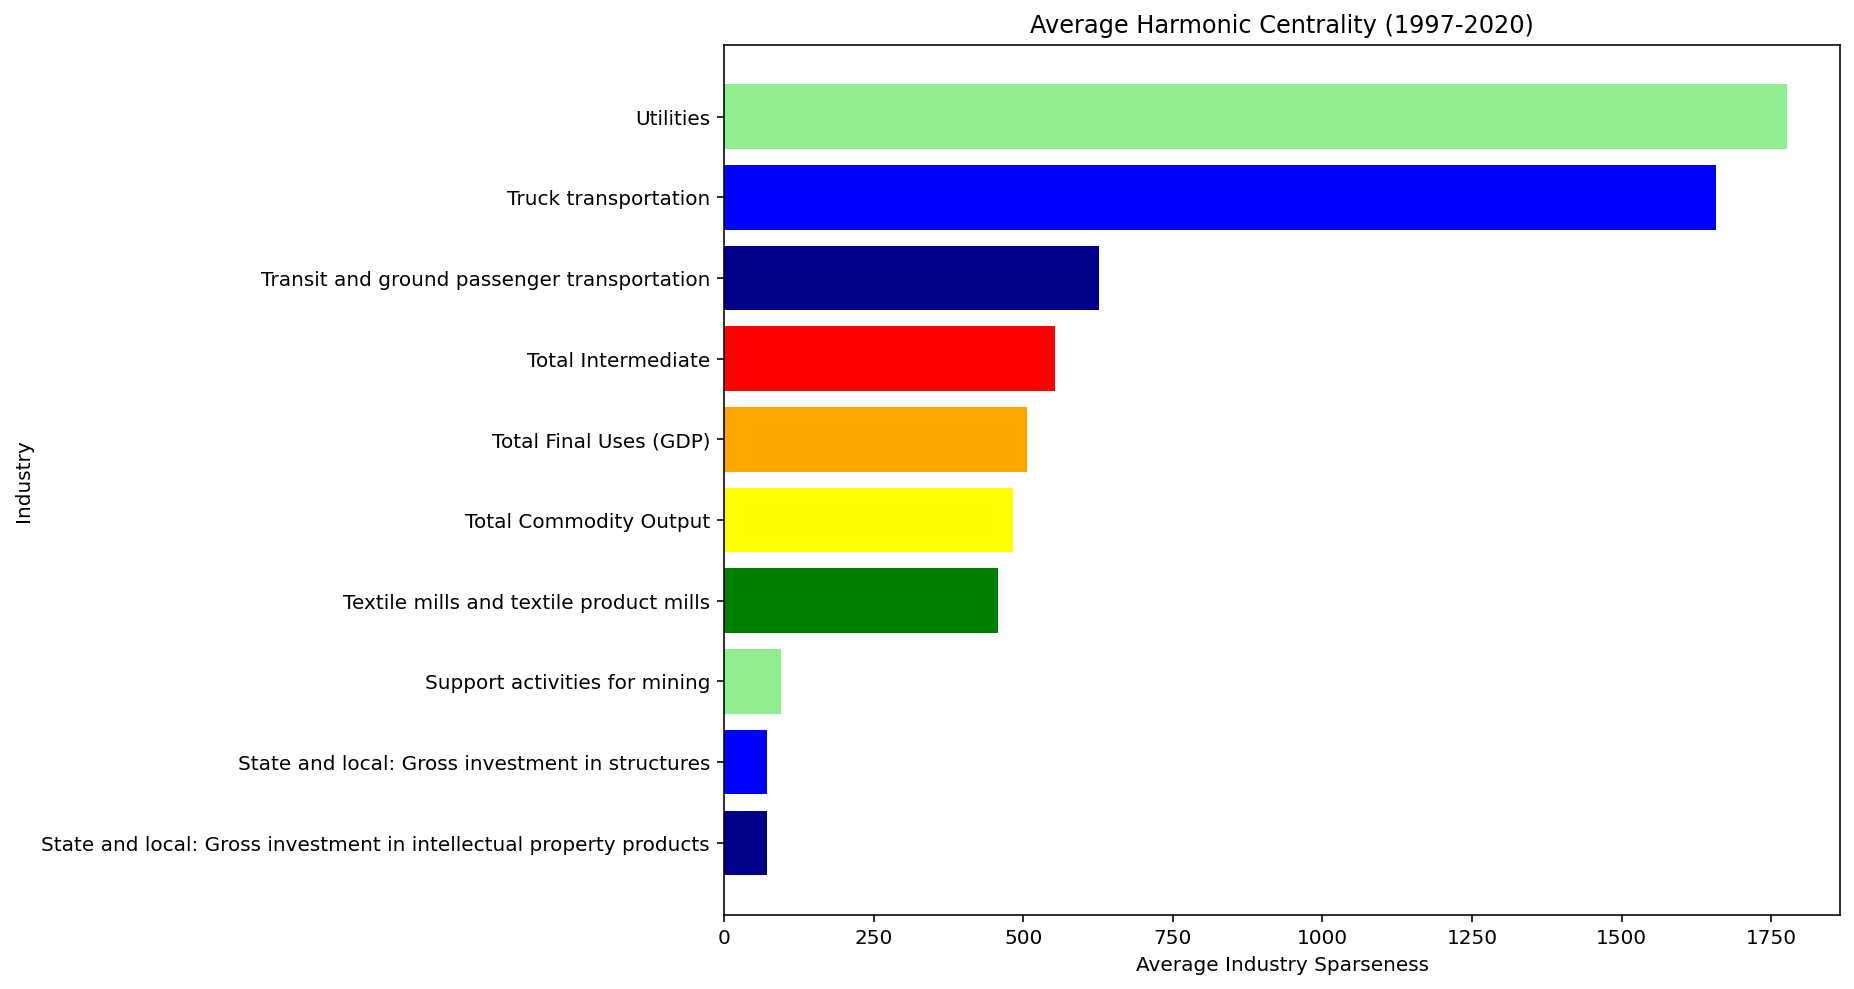

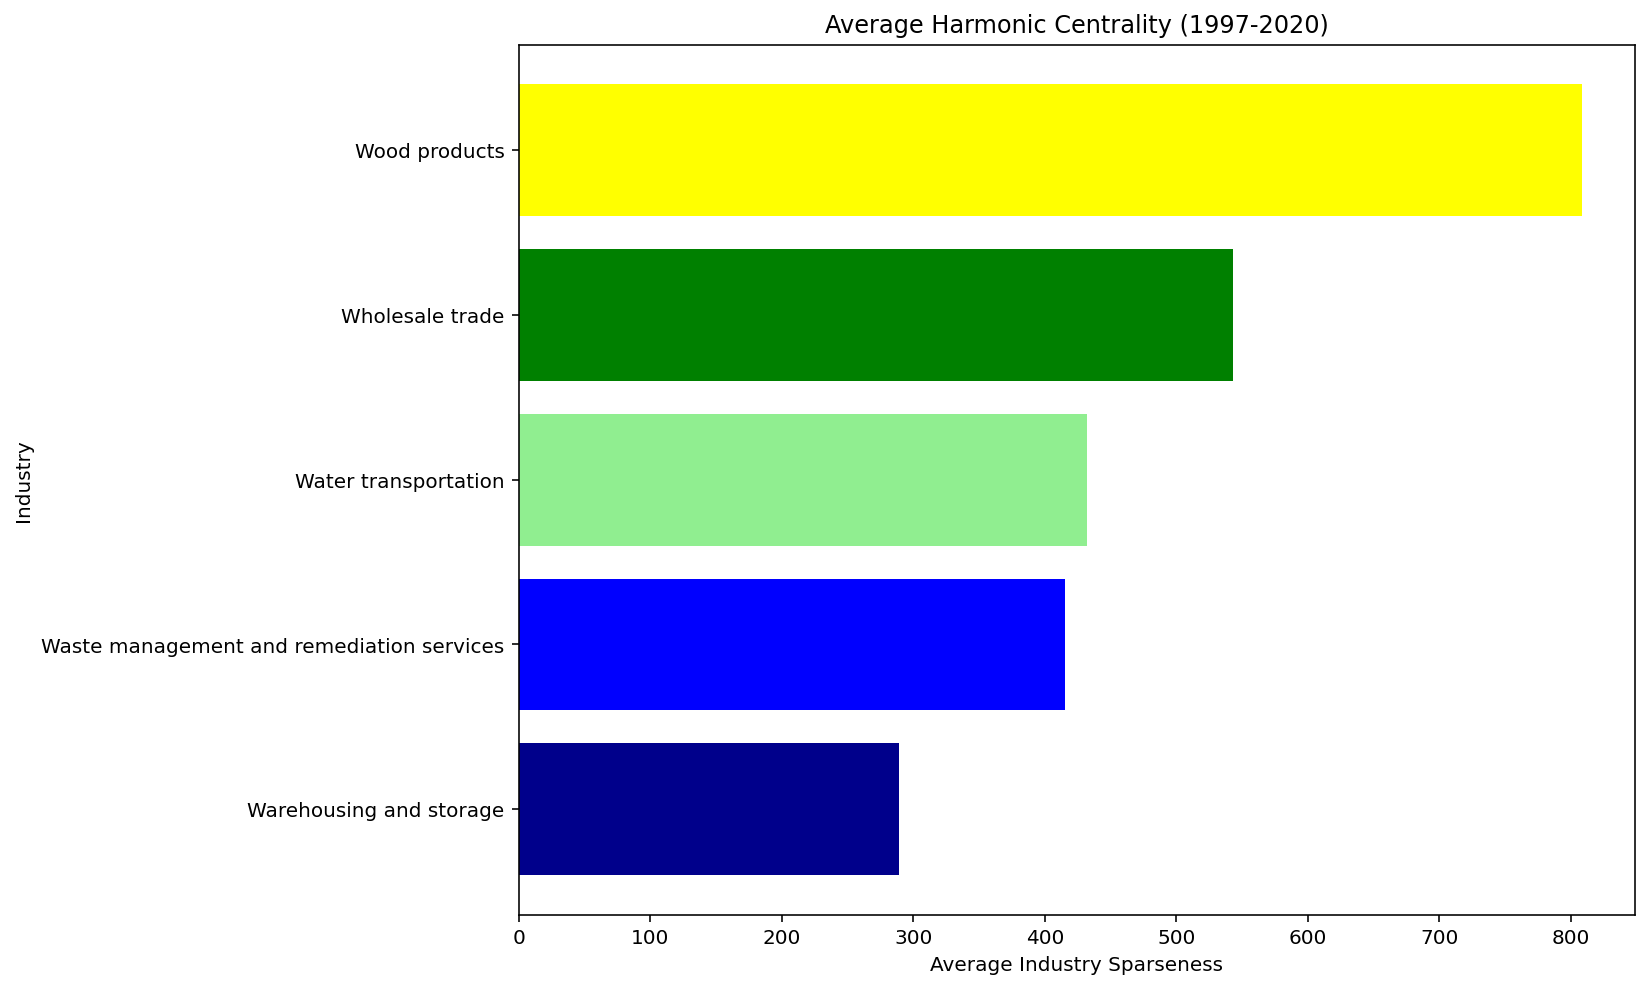

In [14]:
## exploring network centrality/sparsity using the 'harmonic network' metric
plt.rcParams["figure.figsize"] = (10,8)
temp = io_current.set_index('year').isin([0]).sum(axis=0)
col_sparsity = temp.groupby(level=0).sum().reset_index()

## let's try a horizontal bar plor
for i in range(0,len(col_sparsity),10):
    plt.barh(col_sparsity['index'][i:i+10].to_list(),
    col_sparsity.iloc[i:i+10,1].sort_values().to_list(),
    color = ['darkblue', 'blue','lightgreen', 'green','yellow','orange','red'])
    plt.title('Average Harmonic Centrality (1997-2020)')
    plt.ylabel('Industry')  
    plt.xlabel('Average Industry Sparseness')  
    plt.show()

### Correlation Analysis

Due to the extremly large number of industries present in our data, we will be plotting individual cross-crorelation plots with every 10 industries. This is followed by an interactive table where we can explore indiviusal cross-correlation scores between industries.


Definitions:

- Cross-correlation is the comparison of two different time series to detect if there is a correlation between metrics with the same maximum and minimum values. For example: “Are two audio signals in phase?”
Normalized cross-correlation is also the comparison of two time series, but using a different scoring result. Instead of simple cross-correlation, it can compare metrics with different value ranges. For example: “Is there a correlation between the number of customers in the shop and the number of sales per day?”

- Auto-correlation is the comparison of a time series with itself at a different time. It aims, for example, to detect repeating patterns or seasonality. For example: “Is there weekly seasonality on a server website?” “Does the current week’s data highly correlate with that of the previous week?” Normalized auto-correlation is the same as normalized cross-correlation, but for auto-correlation, thus comparing one metric with itself at a different time.

- Time Shift can be applied to all of the above algorithms. The idea is to compare a metric to another one with various “shifts in time”. Applying a time shift to the normalized cross-correlation function will result in a “normalized cross-correlation with a time shift of X”. This can be used to answer questions such as: “When many customers come in my shop, do my sales increase 20 minutes later?”

As you can tell, there are a tremendous number of correlation-based time-series analysis available to us; here, we believe that cross-correlation over time b etween industries will present us the most detail and information about the symbiotic relationships between industries composing the United States Economy. 

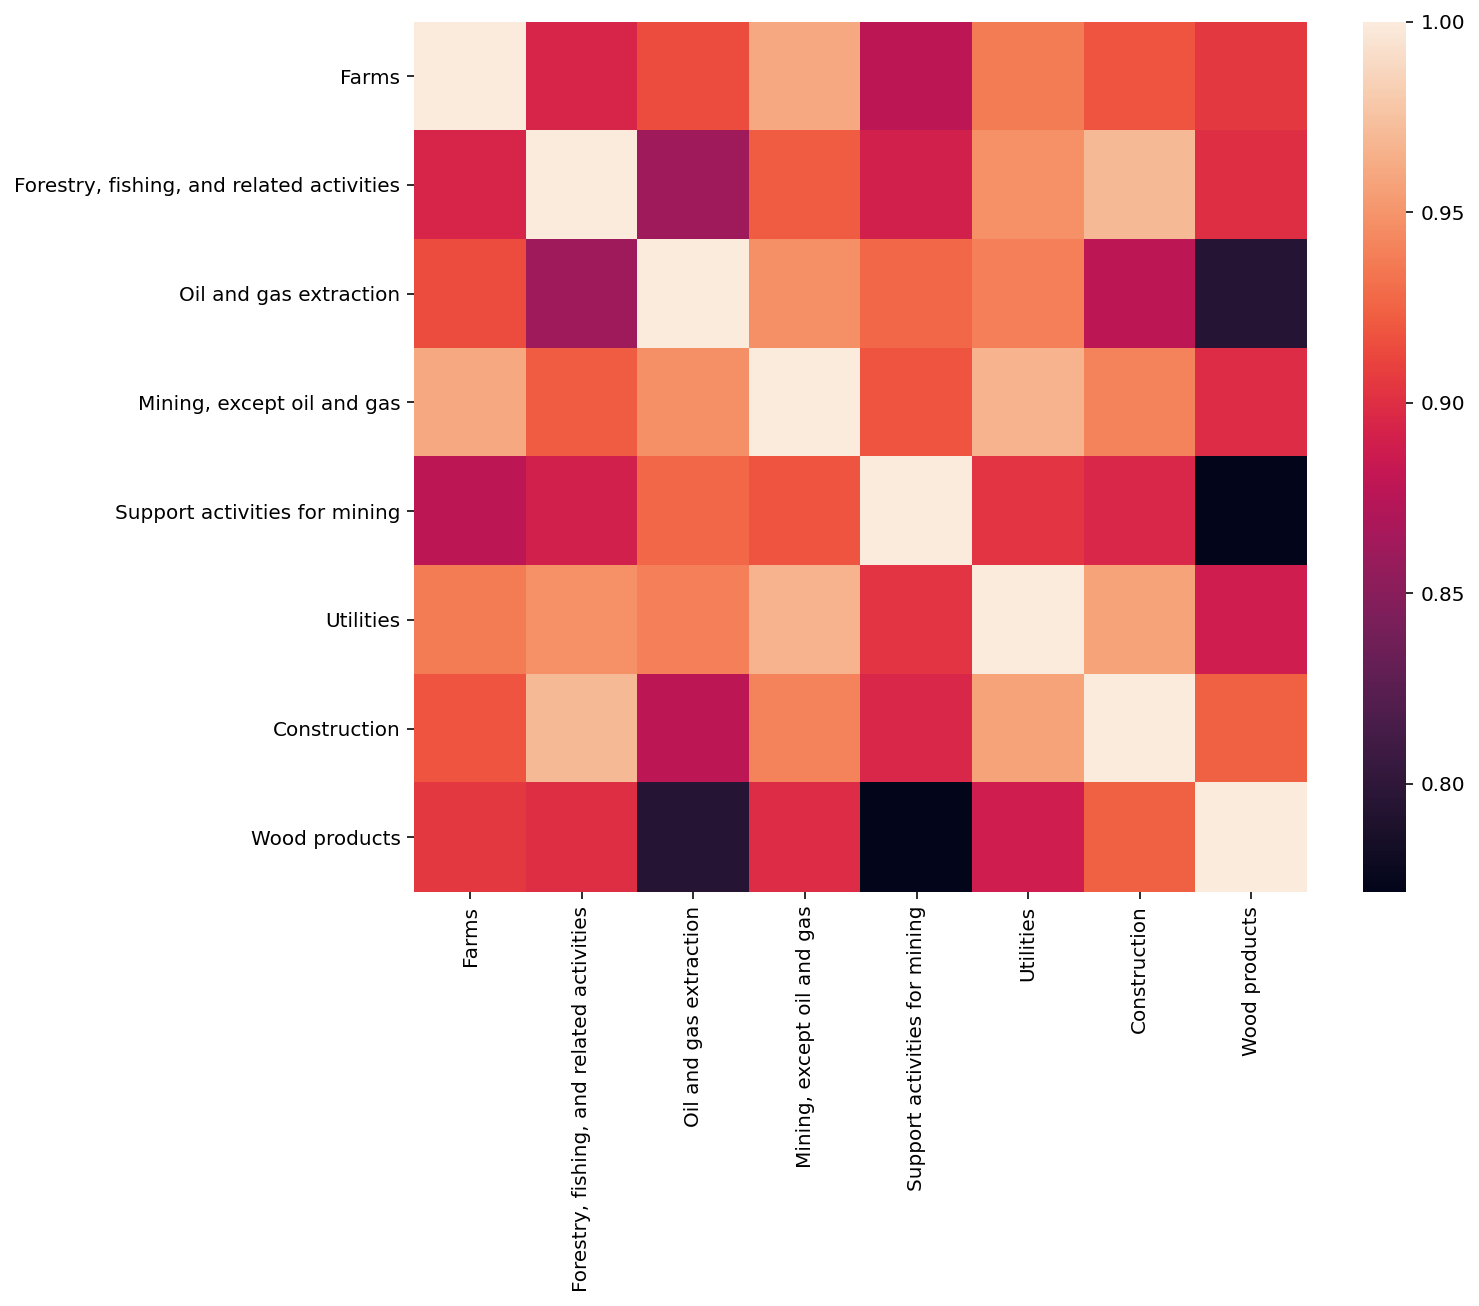

In [15]:
# basic cross-correlation plots
df = io_current

corr = df.iloc[:,1:10].corr()
        # plot the heatmap
sns.heatmap(corr, xticklabels=corr.columns,
                yticklabels=corr.columns)

In [16]:
cmap = cmap = sns.diverging_palette(5, 250, as_cmap=True)

def magnify():
    return [dict(selector="th",
                 props=[("font-size", "7pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])]


corr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Hover to magify")\
    .set_precision(2)\
    .set_table_styles(magnify())

On the contrary, we see a stark cross-correlation matrix for the total requirements table. This agrees with out intuition because 

In [17]:
## correlation plot of sample 5 industries
corr = io_reqs.iloc[0:9,0:9].set_index('Industry Description')
sns.heatmap(corr, xticklabels=corr.columns,
                yticklabels=corr.columns)

NameError: name 'io_reqs' is not defined

In [29]:
cmap = sns.diverging_palette(5, 250, as_cmap=True)

def magnify():
    return [dict(selector="th",
                 props=[("font-size", "7pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])]


corr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Hover to magify")\
    .set_precision(2)\
    .set_table_styles(magnify())

## Probabilistic Graph Models with NetworkX

With respect to our networkX objects, we will be developing functions to transform CSV's into weight matrices, adjacency matrices, and edge plots; these can be directly converted and plotted with functions in the `networkX` package. For the plots below, I believe that we are employing an intuitive design - the structure is as follows:

- Each graph node represents an unique indutry appearing in the IO table of a given year
  
- **Size of nodes** corresponds to the respective contribution of the industry to the total U.S. Economy; larger node sizes represent a larger absolute value for Total Value Added.
  
- **Edge widths** represent the proportion of total materials being sent to the directed node; for example, a larger edge width from `metal machinery -> automobiles` as compared to `metal machinery -> housing` implies that more materials generated by the 'metal & machinery' industry is being sent to the automobily industry as compared to industry of housing. 

**Note: This portion requires utilization of the mapping.json dictionary - this can be found in the `data` subfolder!**

In [5]:
## import our mapping.json dictionary containing shortened industry names
with open("data/category_mapping.json", 'r') as myfile:
    data=myfile.read()

mapping = json.loads(data)

## dictionary of dataframes for easier access
frames = {}
keyList = list(set(io_current['year'].tolist()))

## frames[1997]: return dataframe where year 1997, same for 1998 onwords
for i in keyList:
    frames[i] = io_current[io_current['year'] == i]

NameError: name 'io_current' is not defined

In [30]:
"""
Input: Total Requirements IO table - Pandas Dataframe from CSV:
    - needs to be of the following form: 
    - do not feed in combined dataframe - needs to be year by year
    - example below

Output: 

Adjacency Matrix: |V| x |V| matrix -> can save as sparse style matrix

Adjacency List: same information as Adjacency Matrix - dictionary where each industry
is a key and values for each key is a list of connected industries 

Edge List: Allows for weighted edges of differing sizes -> contains list of tuples 
where each tuple is a industry combination that has a connecting edge for first two elements;
third element is its assigned directional weight; i.e. (Farms,Automobile,0.2) != (Automobile,Farms,1)

NewtorkX.G object with pre-built labels

"""
class IO:

    def to_weight_matrix(self, x: pd.DataFrame):
        test = x.set_index('Name')
        rows = test.index.to_list(); cols = test.columns.tolist()
        diff = list(set(cols) - set(rows)); diff2 = list(set(rows) - set(cols))
        weight = test.drop(diff, axis = 1).drop(diff2, axis = 0)
        weight.update(weight.div(weight.sum(axis=0),axis=1))
        return weight

    def to_adj_matrix(self, x : pd.DataFrame):
        res = self.to_weight_matrix(x)
        res[res!= 0] = 1
        return res  

    def to_adj_list(self, x : pd.DataFrame):
        res = self.to_adj_matrix(x)
        industries = res.index.to_list()
        for i in range(0,res.shape[0]):
            for j in range(0,res.shape[1]):
                if i == j:
                    res.iloc[i,j] = 0
                if str(int(res.iloc[i,j])) == '1':
                    res.iloc[i,j] = res.columns[j]          
        master = res.values.tolist()
        temp = [[y for y in x if y != 0] for x in master]
        edges = {industries[i]: temp[i] for i in range(0,len(temp))}
        return edges

    def to_edge_list(self, x : pd.DataFrame):
        edge = self.to_adj_list(x)
        weights = self.to_weight_matrix(x)
        industries = [*edge.keys()]
        temp = []
        for i in range(len(industries)):
            for j in range(len(edge[industries[i]])):
                if weights.iloc[i,j] != 0:
                    k = (industries[i], edge[industries[i]][j], weights.iloc[i,j])
                    temp.append(k)  
        return pd.DataFrame(temp, columns = ['from','to','weights'])
        
    def to_network(self, x):
        network = self.to_adj_matrix(x)
        G = nx.from_pandas_adjacency(network)
        G = nx.relabel_nodes(G, mapping)
        return(G)

## Sample Visualizations

This section contains sample network graphs created with the function above - the actual analysis done on this network and tangible results can be found in the modeling notebook. Note that this section may be helpful if you are interested in the creation of self-loops and higher-level plots with NewtworkX. A detailed introduction and documentation file may be found at the [NetworkX homepage](https://networkx.org). We will be exploring the permutations induced throhgb the `options` statement alongside different plot layouts with the `pos()` argument; one tricky aspect of networkX plots is the implementation of size-variant nodes and edges - this requires non-standard scaling values which is explained both in the documentation and comments in the code below.

In [4]:
## Example for year 1997
test = frames[1997]
io = IO()
weight = io.to_weight_matrix(test) ## weight matrix
res = io.to_adj_matrix(test) ## pandas adjacency matrix 
adj_list = io.to_adj_list(test) ## adjacency list
edge = io.to_edge_list(test) ## edge list with weights
GG = io.to_network(test)

NameError: name 'frames' is not defined

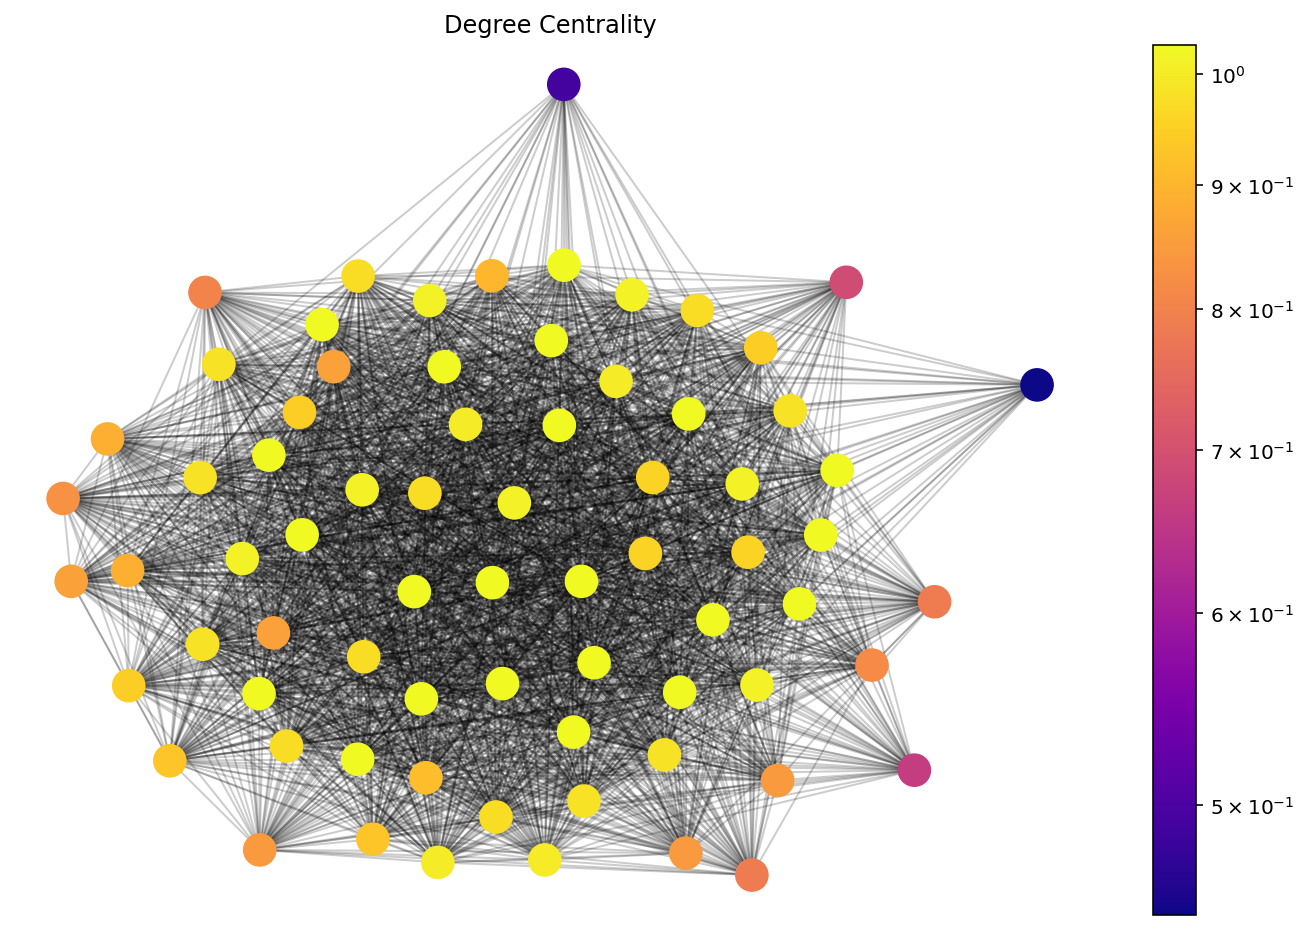

In [56]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# for Notebook
%matplotlib inline
def draw(G, pos, measures, measure_name):
    
    nodes = nx.draw_networkx_nodes(G, pos, node_size=250, cmap=plt.cm.plasma, 
                                   node_color=list(measures.values()),
                                   nodelist=measures.keys())
    nodes.set_norm(mcolors.SymLogNorm(linthresh=0.01, linscale=1, base=10))
    # labels = nx.draw_networkx_labels(G, pos)
    edges = nx.draw_networkx_edges(G, pos, alpha=0.2)

    plt.title(measure_name)
    plt.colorbar(nodes)
    plt.axis('off')
    plt.show()
plt.rcParams["figure.figsize"] = (12,8)
pos = nx.spring_layout(GG, seed=675)
DiG = nx.DiGraph()
draw(GG, pos, nx.degree_centrality(GG), 'Degree Centrality')

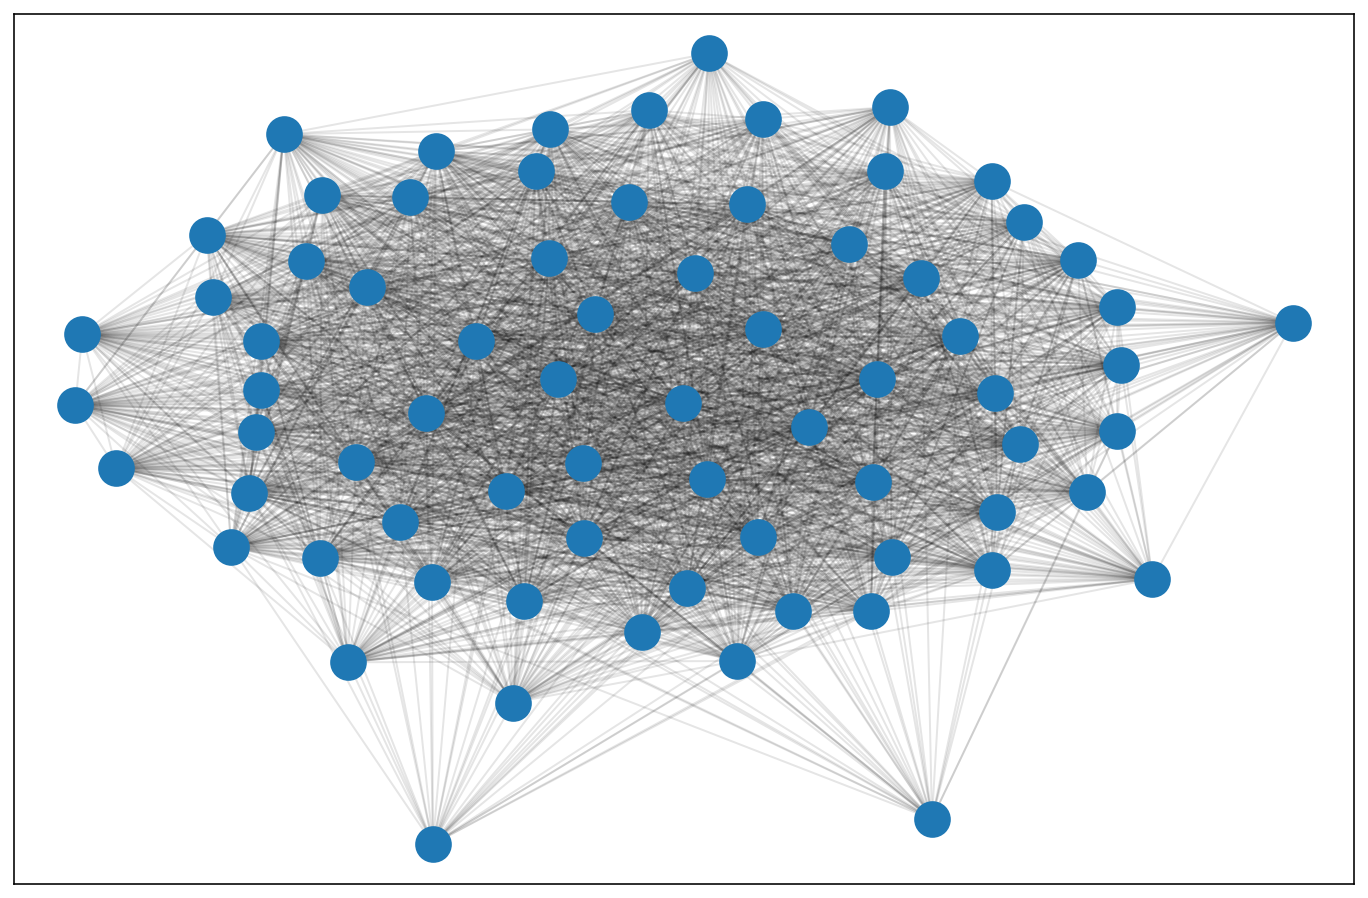

In [58]:
## pandas adjacency matrix -> networkX plot
res = io.to_adj_matrix(test) 
options = {
    "font_size": 12,
    "font_color": "black",
    "node_size": 8000,
    "node_color": "blue",
    "edgecolors": "lightblue"
}
## with custom options above
G = nx.from_pandas_adjacency(res)
G = nx.relabel_nodes(G, mapping)
# Compute position of nodes
pos = nx.spring_layout(G)
# Draw nodes and edges
nx.draw_networkx_nodes(G, pos, with_labels = True)
nx.draw_networkx_edges(
    G, pos, alpha=0.1  
)
plt.show()

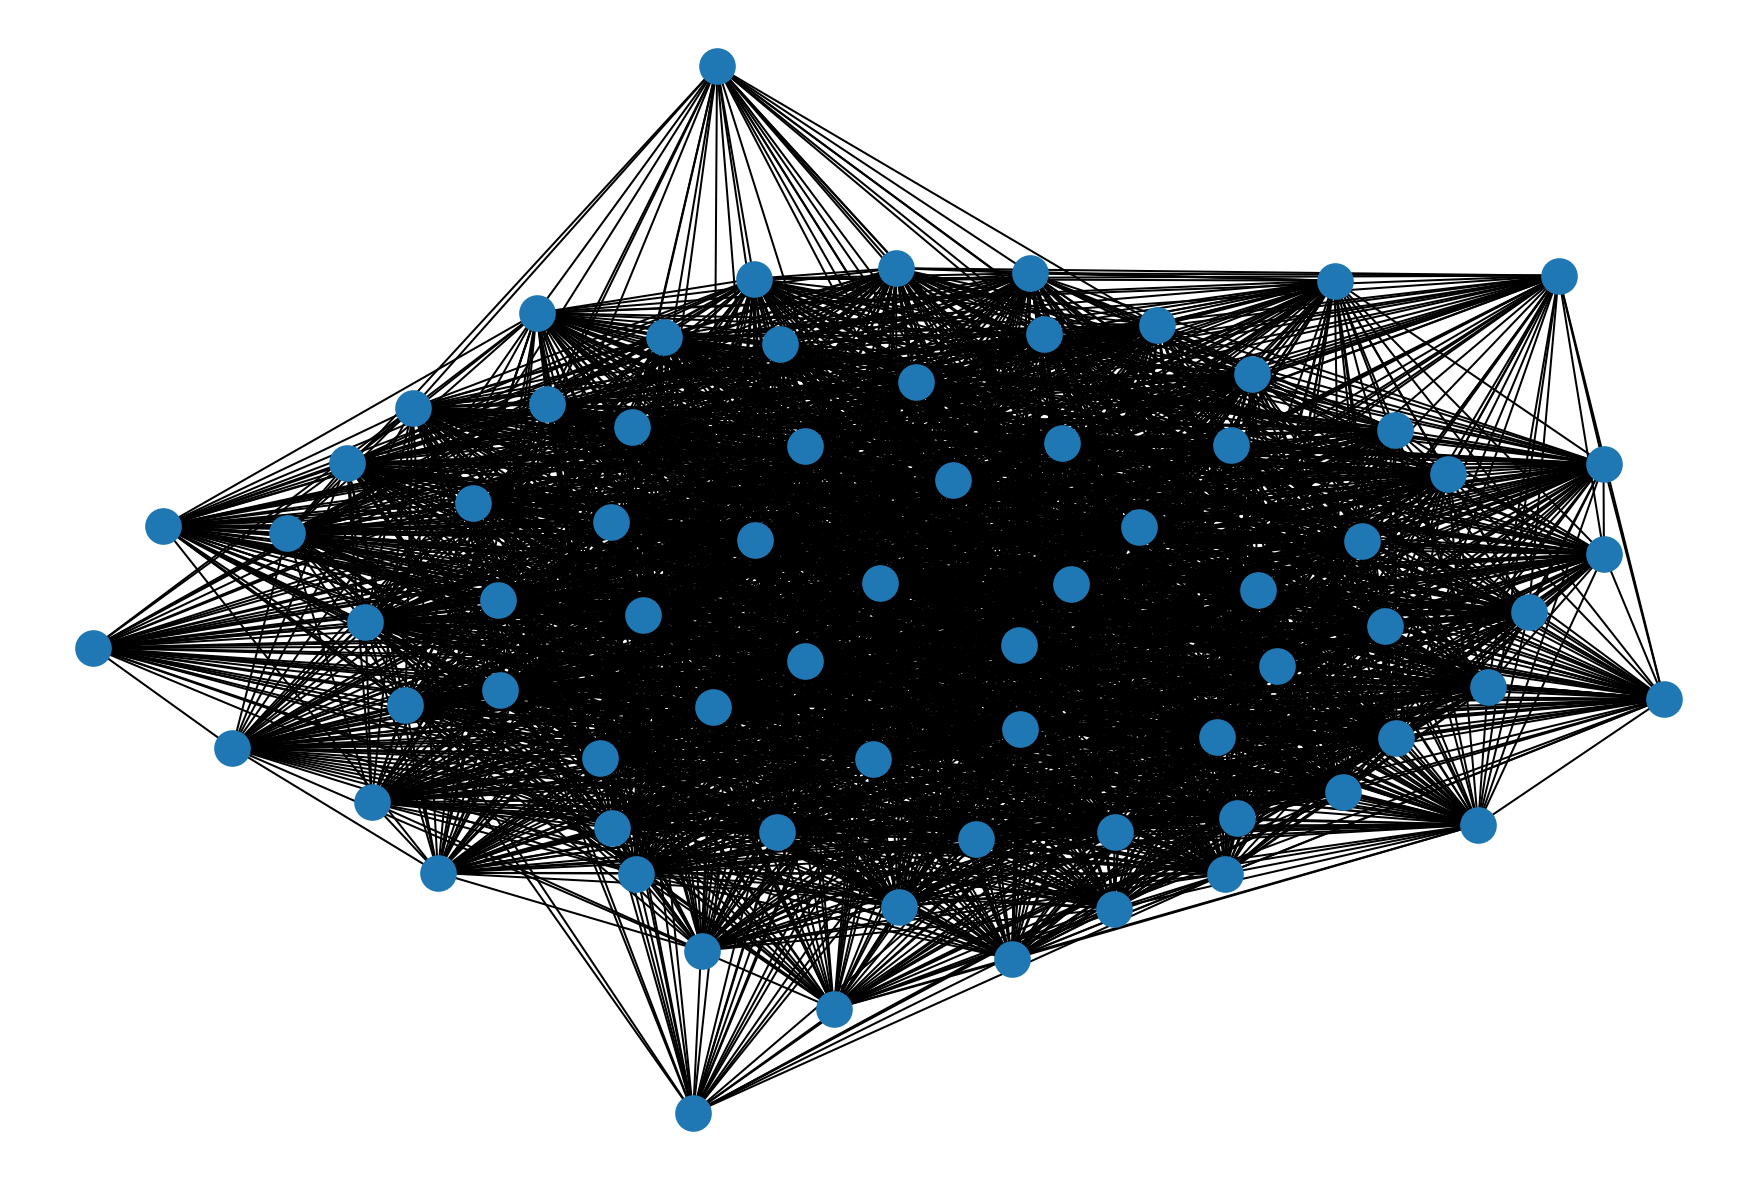

In [59]:
## playing around with the options allows for aestethic changes 
options = {
    "font_size": 12,
    "font_color": "white",
    "node_size": 2000,
    "node_color": "blue",
    "edgecolors": "lightblue"
}

## centrality-based network plot -> color coded by harmonic centrality score
G = nx.from_pandas_adjacency(res)
G = nx.relabel_nodes(G, mapping)
nx.draw(G, with_labels = False) 
plt.show()

In [60]:
## master is a list of edge lists for each year [1997-2020] 
## -> we can use this to explore network perturbations over time
complete = list(frames.values())
master = [None] * len(complete)

for i in range(0,len(complete)):
    master[i] = io.to_edge_list(complete[i])

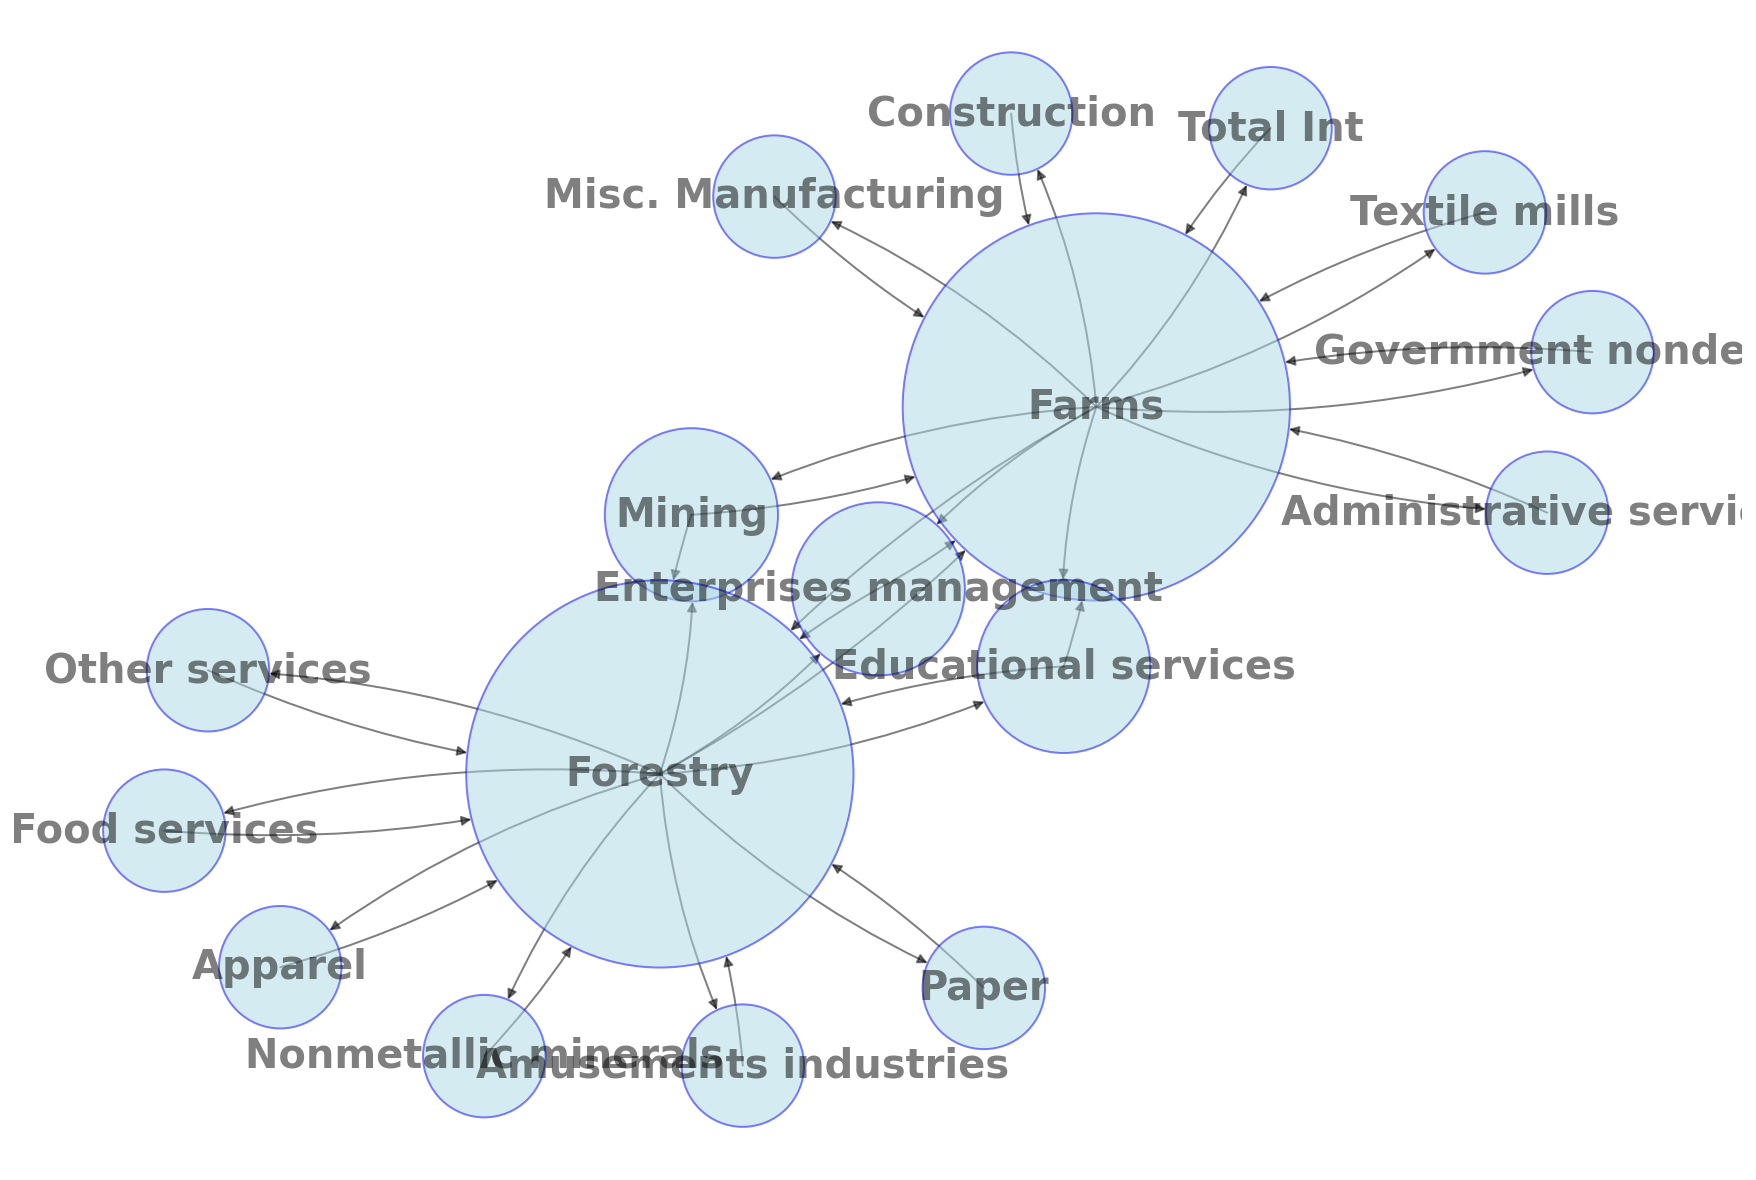

In [61]:
# sample directed acrylic graph given first sample 20 industries from 1997
options = {
    "font_size": 20,
    "font_color": "black",
    "node_color": "lightblue",
    "edgecolors": "blue",
    "with_labels": True,
    "alpha": 0.5
}

subset  = nx.from_pandas_edgelist(edge.iloc[1:20,], 'from', 'to')
G = nx.DiGraph(subset)
pos = nx.spring_layout(G)
G = nx.relabel_nodes(G, mapping)
central = nx.degree_centrality(G)
central ## centrality table
#plt.axis('equal') -> "squared" image
nx.draw(G, **options, font_weight = "bold", connectionstyle='arc3, rad = 0.1', 
                      node_size=[central[i] * 30000  for i in G.nodes()])

<ipython-input-62-e552ec3bc3a9>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  farms['weights'] = farms['weights'].apply(lambda x: x*50) ## scale weights by factor of 100


{'Oil & Gas': Text(-0.002881315826064793, -0.0029391468747794022, 'Oil & Gas'),
 'Wood': Text(0.5645682253283186, 0.35776147194579244, 'Wood'),
 'Primary metals': Text(0.4857098419916457, -0.40709693541327413, 'Primary metals'),
 'Food products': Text(-0.6264607059430362, -0.6589123698451668, 'Food products'),
 'Printing': Text(-0.9776192701989189, 0.3050718040035633, 'Printing'),
 'Chemical products': Text(0.5632592434983092, -0.8345091036170279, 'Chemical products'),
 'Plastics & Rubber': Text(-0.32858012585507823, -0.9848725613809175, 'Plastics & Rubber'),
 'Publishing industries': Text(-0.6856662142028347, 0.7381071115621227, 'Publishing industries'),
 'Computer systems': Text(0.014240404355750483, 0.6552638572174307, 'Computer systems'),
 'Professional services': Text(-0.851075480132822, -0.07772488785702816, 'Professional services'),
 'Enterprises management': Text(0.95306334166586, 0.3682485245636776, 'Enterprises management'),
 'Administrative services': Text(-0.925496278706217

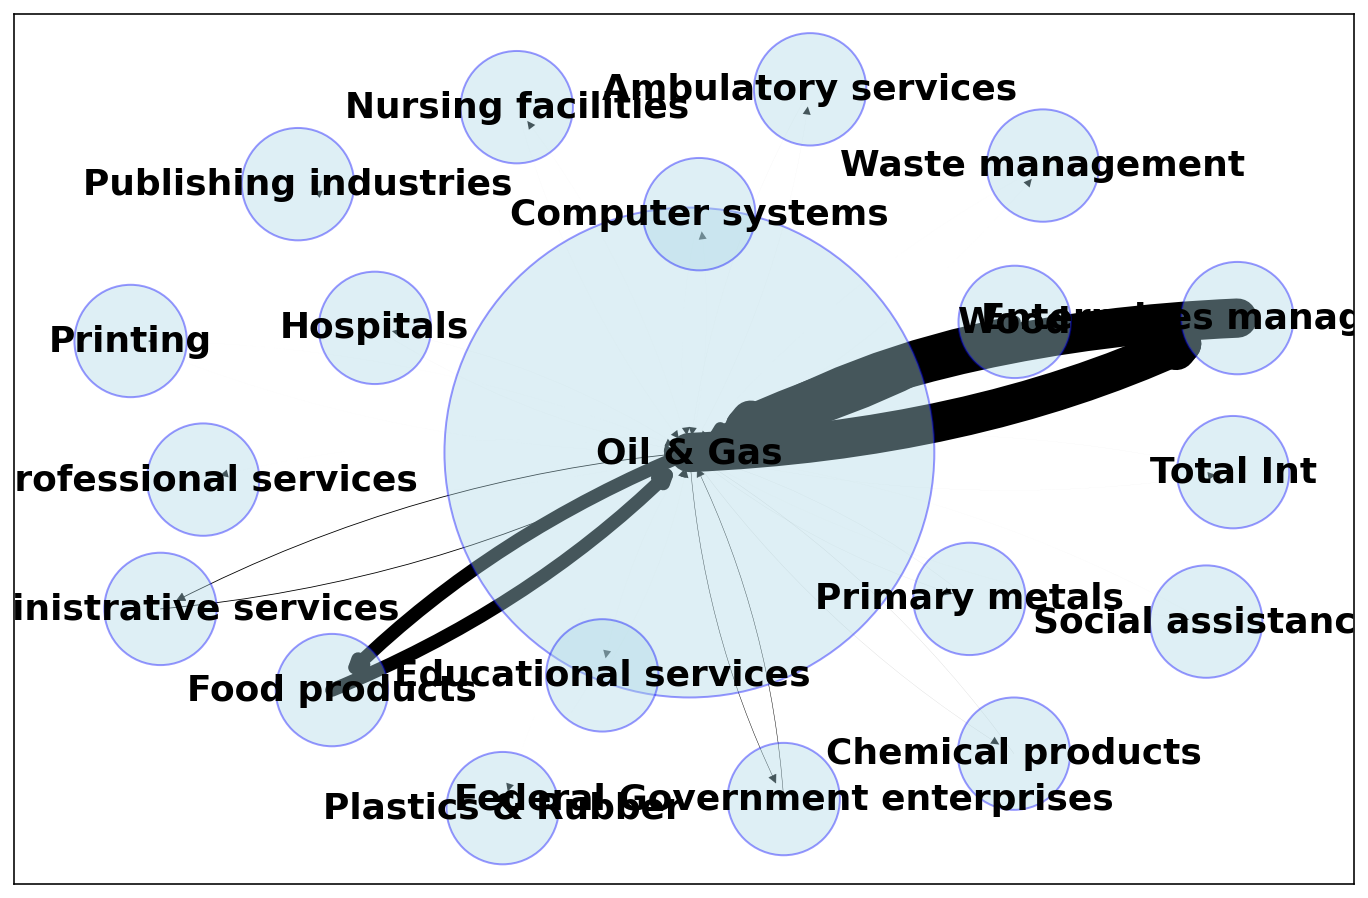

In [62]:
options = {
    "font_size": 12,
    "font_color": "black",
    "node_color": "lightblue",
    "edgecolors": "blue",
    "with_labels": True,
}

farms = edge[edge['from'] ==  'Oil and gas extraction']
farms['weights'] = farms['weights'].apply(lambda x: x*50) ## scale weights by factor of 100
farms2 = nx.from_pandas_edgelist(farms, 'from', 'to', edge_attr='weights')

G = nx.MultiDiGraph(farms2, font_weight = "bold")
G = nx.relabel_nodes(G, mapping)

pos = nx.spring_layout(G)
central = nx.degree_centrality(G)
widths = nx.get_edge_attributes(G, 'weights')
nodelist = G.nodes()

## Draw nodes and edges
nx.draw_networkx_edges(
    G, pos,
    connectionstyle = "arc3, rad = 0.1",  
    edgelist = widths.keys(), 
    width = list(widths.values()), col = 'red' )

nx.draw_networkx_nodes(G, pos, **options,
                        node_size=[central[i] * 30000  for i in G.nodes()], alpha = 0.4)

nx.draw_networkx_labels(G, pos=pos,
                        labels=dict(zip(nodelist,nodelist)),
                        font_color='black', font_weight="bold", font_size = '18')

## Time-Variant Plots

Finally, let's explore possible options for depiciting the network economic network over time. Due to the prescence of multi-decade data through the BEA, I will be dedicating a small paragraph to the possibility of time-variant plots in the form of gifs or built internally through the `plotly` package. Although no information sorrounding the analaysis of year-indexed IO supply data is presented here, we will dive into deeper details alongside a sample model-implementation in the `model-Andrew.ipynb` notebook. 

The analysis of economic network change over time is a relatively contemporary method due to its reliance on large compuational power - more information on implementation can be found in this [Economics Paper](https://econpapers.repec.org/article/fipfedker/00052.htm). 

<ipython-input-44-adadf9c6c3cd>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  farms['weights'] = farms['weights'].apply(lambda x: x*100) ## scale weights by factor of 100


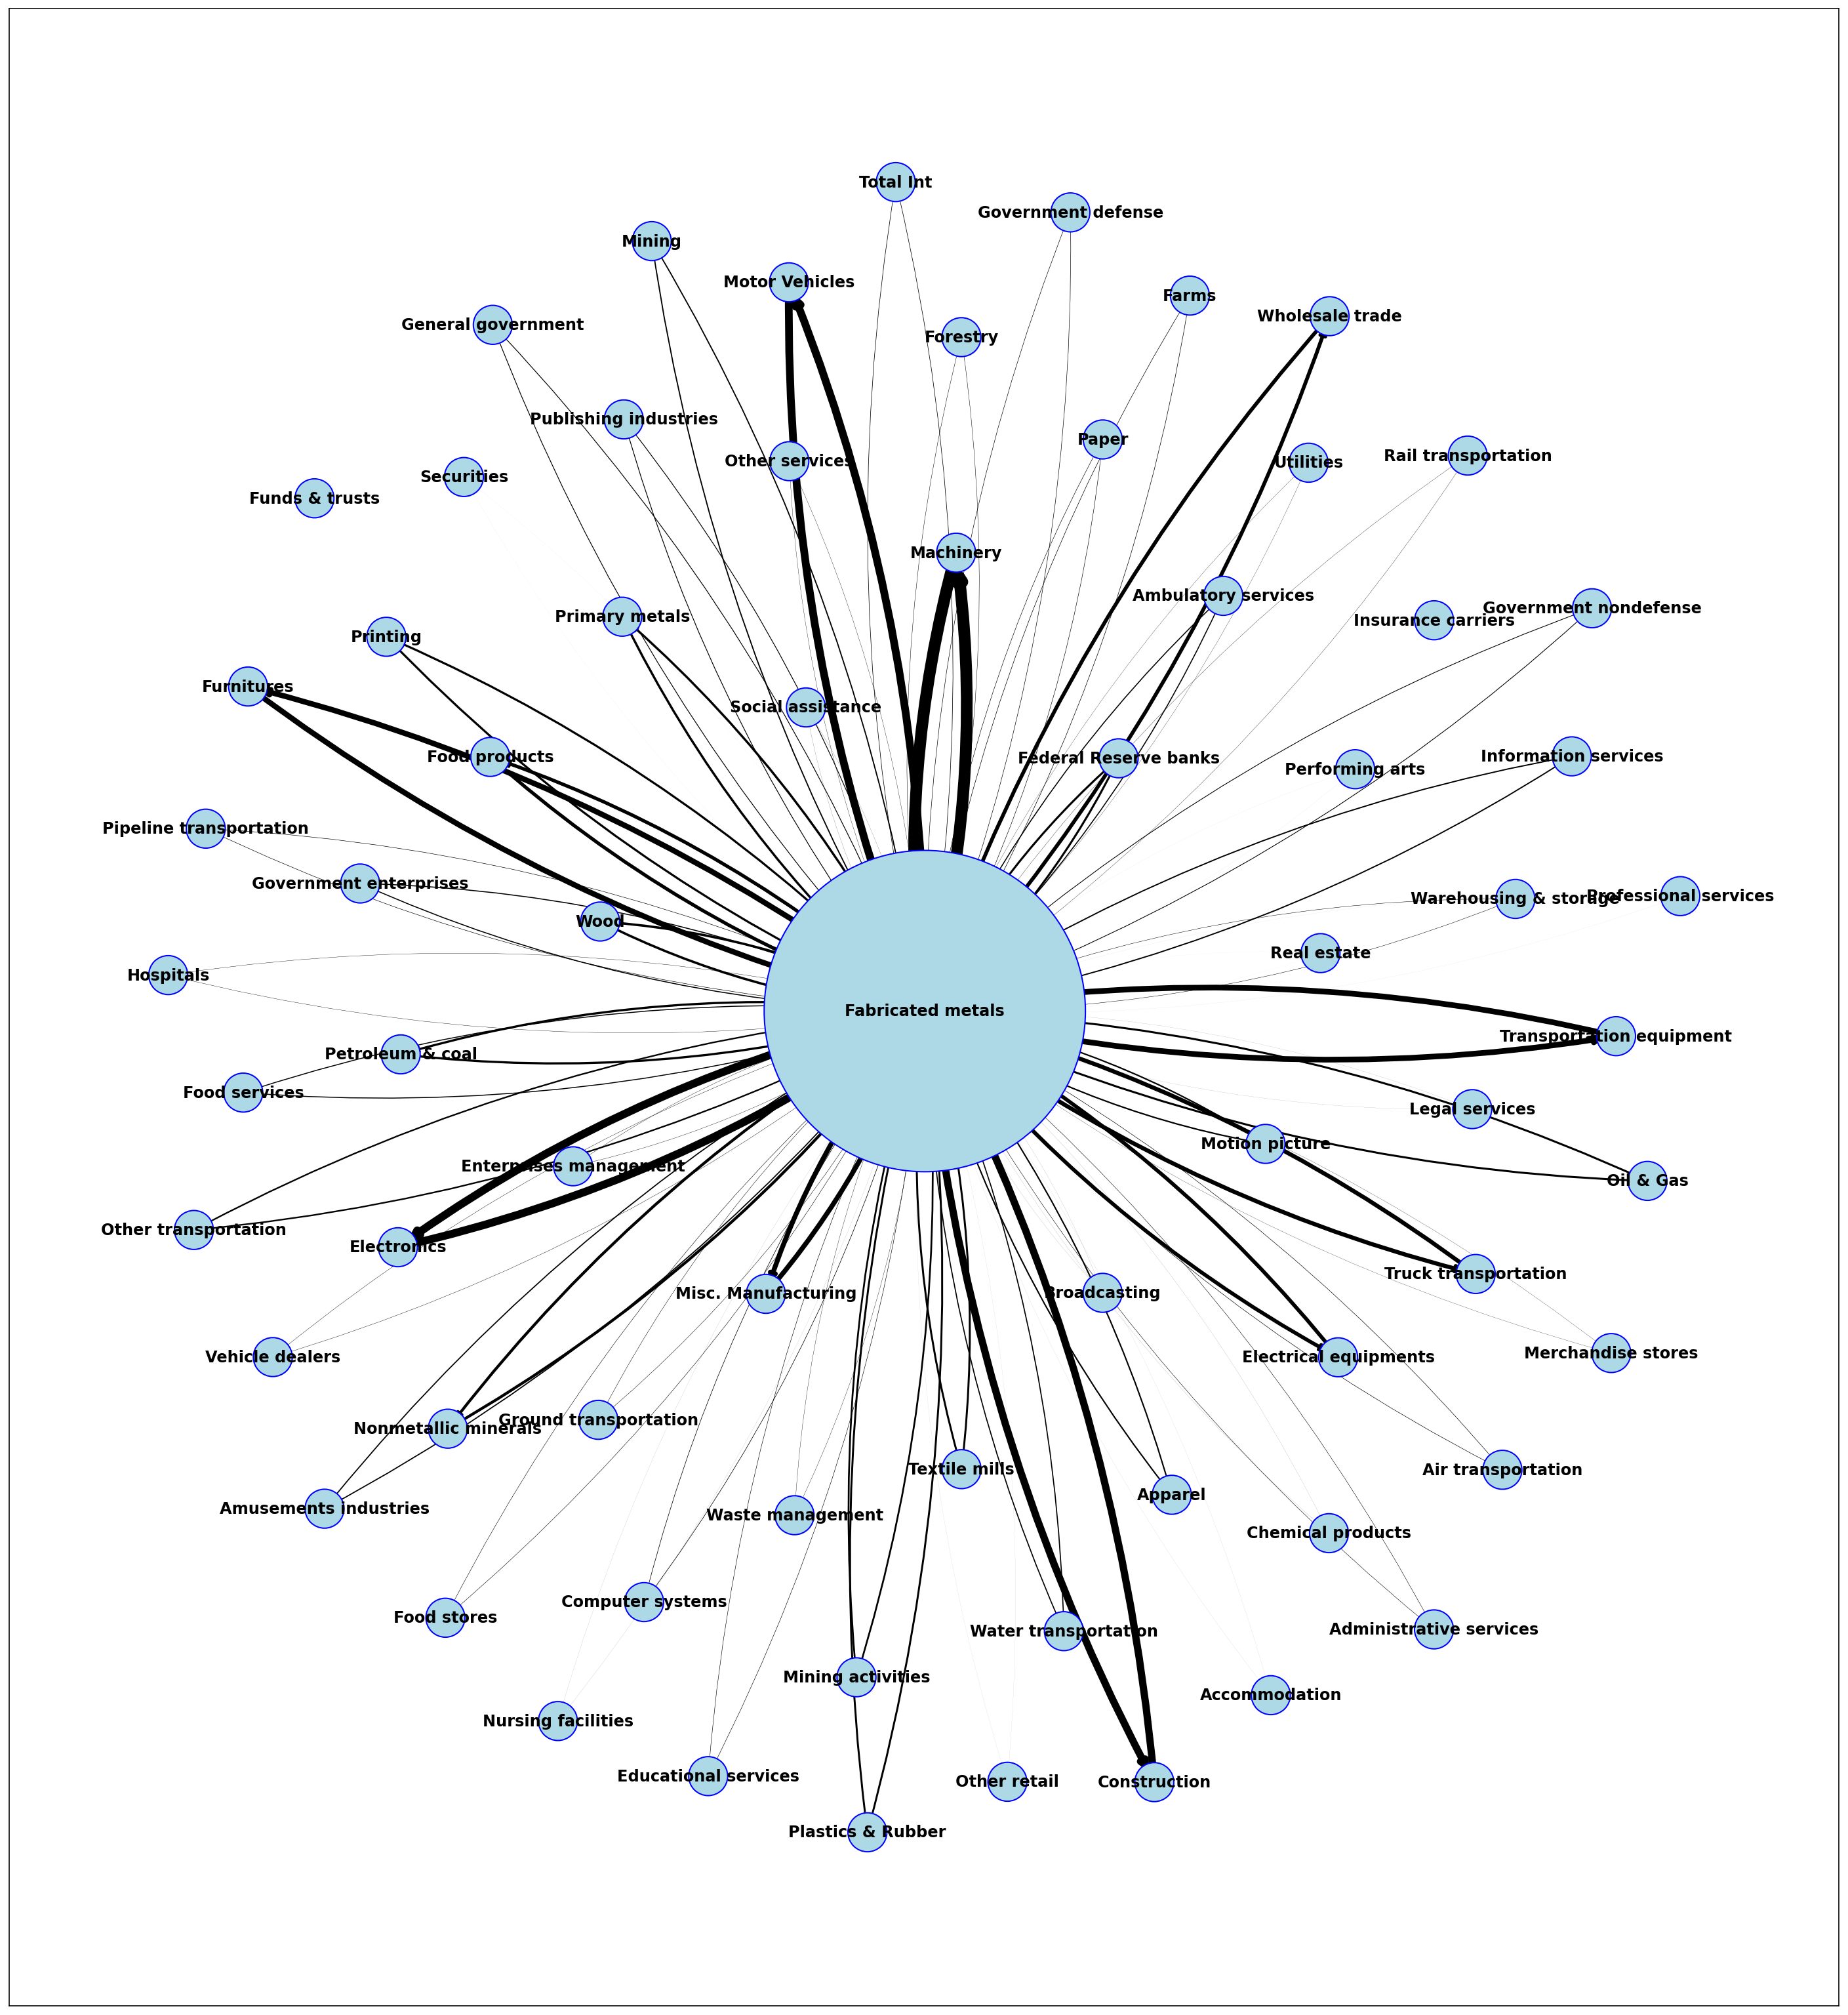

In [44]:
plt.rcParams["figure.figsize"] = (25,28)

def plot_time(edge, industry):

    options = {
    "font_size": 12,
    "font_color": "black",
    "node_color": "lightblue",
    "edgecolors": "blue",
    "with_labels": True,
}
    farms = edge[edge['from'] == industry]
    farms['weights'] = farms['weights'].apply(lambda x: x*100) ## scale weights by factor of 100

    farms2 = nx.from_pandas_edgelist(farms, 'from', 'to', edge_attr='weights')

    G = nx.MultiDiGraph(farms2, font_weight = "bold")
    G = nx.relabel_nodes(G, mapping)

    pos = nx.spring_layout(G)
    central = nx.degree_centrality(G)
    widths = nx.get_edge_attributes(G, 'weights')
    nodelist = G.nodes()

    ## Draw nodes and edges
    nx.draw_networkx_edges(
        G, pos,
        connectionstyle = "arc3, rad = 0.1",  
        edgelist = widths.keys(), 
        width = list(widths.values()))

    nx.draw_networkx_nodes(G, pos, **options, connectionstyle="arc3, rad=0.1", node_size=[central[i] * 30000  for i in G.nodes()])

    nx.draw_networkx_labels(G, pos=pos,
                            labels=dict(zip(nodelist,nodelist)),
                            font_color='black', font_weight="bold", font_size = '12')

    plt.show()
    
plot_time(edge, 'Fabricated metal products')

In [46]:
## network plots over time
#for i in master:
#    plot_time(i, 'Fabricated metal products')

## References
1. Jason Choi and Andrew Foerster, (2017), The Changing Input-Output Network Structure of the U.S. Economy, Economic Review, (Q II), 23-49